<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-8i1_yu6g
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-8i1_yu6g
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 174 kB 65.2 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 42.9 MB/s 
     |██████

In [1]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
from finrl.finrl_meta.data_processors.processor_alpaca import AlpacaProcessor
from finrl.finrl_meta.data_processors.processor_wrds import WrdsProcessor
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_conservative import StockTradingEnvCon
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot2 import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [3]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE

'2014-01-01'

In [4]:
# from config.py TRAIN_END_DATE is a string
# config.TRAIN_END_DATE
# df2=TushareDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [5]:
# df = YahooDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [6]:
# print(config_tickers.DOW_30_TICKER)

In [7]:
df=pd.read_csv('./1.csv')
df.shape

(94360, 9)

In [8]:
df.sort_values(['date','tic'],ignore_index=True).head()

,Unnamed: 0,date,open,high,low,close,volume,tic,day
0,0,2008-12-31,3.070357,3.133571,3.047857,2.606277,607541200,AAPL,2
1,1,2008-12-31,57.110001,58.220001,57.060001,43.924454,6287200,AMGN,2
2,2,2008-12-31,17.969999,18.750000,17.910000,14.908465,9625600,AXP,2
3,3,2008-12-31,41.590000,43.049999,41.500000,32.005894,5443100,BA,2
4,4,2008-12-31,43.700001,45.099998,43.700001,30.628819,6277400,CAT,2


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [9]:
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     tech_indicator_list = config.INDICATORS,
#                     use_vix=True,
#                     use_turbulence=True,
#                     user_defined_feature = False)

# processed = fe.preprocess_data(df)

In [10]:
# list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

# processed_full = processed_full.fillna(0)

In [11]:
processed_full=pd.read_csv('./2.csv')
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.606277,607541200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,2.606277,2.606277,40.0,0.0
1,1,2008-12-31,AMGN,57.110001,58.220001,57.060001,43.924454,6287200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.924454,43.924454,40.0,0.0
2,2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.908465,9625600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,14.908465,14.908465,40.0,0.0
3,3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005894,5443100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,32.005894,32.005894,40.0,0.0
4,4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.628819,6277400.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,30.628819,30.628819,40.0,0.0
5,5,2008-12-31,CRM,7.712500,8.130000,7.707500,8.002500,5367600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,8.002500,8.002500,40.0,0.0
6,6,2008-12-31,CSCO,16.180000,16.549999,16.120001,11.787783,37513700.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,11.787783,11.787783,40.0,0.0
7,7,2008-12-31,CVX,72.900002,74.629997,72.900002,43.314438,9964300.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.314438,43.314438,40.0,0.0
8,8,2008-12-31,DIS,22.570000,22.950001,22.520000,19.538342,9012100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,19.538342,19.538342,40.0,0.0
9,9,2008-12-31,GS,82.239998,86.150002,81.120003,69.224182,14894100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,69.224182,69.224182,40.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [12]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [13]:
train.tail()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,121795,2020-06-30,UNH,288.570007,296.450012,287.660004,287.776794,2932900.0,1.0,-0.019475,303.925869,271.251255,52.413046,-25.838431,1.846804,288.020689,281.001438,30.43,12.918751
2892,121796,2020-06-30,V,191.490005,193.750000,190.160004,190.737244,9040100.0,1.0,1.048786,198.750528,185.041391,53.021033,-51.550760,2.013358,191.485037,181.677683,30.43,12.918751
2892,121797,2020-06-30,VZ,54.919998,55.290001,54.360001,50.376743,17414800.0,1.0,-0.437111,53.918425,48.729324,48.097044,-51.018262,8.508886,51.012123,51.464679,30.43,12.918751
2892,121798,2020-06-30,WBA,42.119999,42.580002,41.759998,39.035732,4782100.0,1.0,-0.083986,42.609305,36.487095,48.830181,-14.508130,1.500723,39.135190,38.935129,30.43,12.918751
2892,121799,2020-06-30,WMT,119.220001,120.129997,118.540001,116.121765,6836400.0,1.0,-0.886569,119.473758,113.510454,48.159665,-69.938795,3.847271,117.787627,119.723273,30.43,12.918751


In [14]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [15]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [16]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [17]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

e_train_gym_conservative = StockTradingEnvCon(df = train, **env_kwargs)

## Environment for Training



In [18]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
env_train_con, _ = e_train_gym_conservative.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [19]:
agent = DRLAgent(env = env_train)
agent_con = DRLAgent(env = env_train_con)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [62]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 67         |
|    iterations         | 100        |
|    time_elapsed       | 7          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -1.41      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -72.8      |
|    reward             | 0.19451597 |
|    std                | 1          |
|    value_loss         | 3.68       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 68         |
|    iterations         | 200        |
|    time_elapsed       | 14         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -0.115     |
|    learning_rate      |

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 1500      |
|    time_elapsed       | 108       |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -39.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | 169       |
|    reward             | 4.8591986 |
|    std                | 1.01      |
|    value_loss         | 21.7      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 1600       |
|    time_elapsed       | 115        |
|    total_timesteps    | 8000       |
| train/                |            |
|    entropy_loss       | -40        |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 2900      |
|    time_elapsed       | 209       |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -40.1     |
|    explained_variance | 0.88      |
|    learning_rate      | 0.0007    |
|    n_updates          | 2899      |
|    policy_loss        | -116      |
|    reward             | 2.3091433 |
|    std                | 1.01      |
|    value_loss         | 9.5       |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 3000       |
|    time_elapsed       | 216        |
|    total_timesteps    | 15000      |
| train/                |            |
|    entropy_loss       | -40.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 4300      |
|    time_elapsed       | 309       |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -40.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 4299      |
|    policy_loss        | -64       |
|    reward             | 3.9822705 |
|    std                | 1.02      |
|    value_loss         | 3.59      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 4400       |
|    time_elapsed       | 317        |
|    total_timesteps    | 22000      |
| train/                |            |
|    entropy_loss       | -40.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 5600        |
|    time_elapsed       | 403         |
|    total_timesteps    | 28000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 5599        |
|    policy_loss        | -46.9       |
|    reward             | -0.06746031 |
|    std                | 1.02        |
|    value_loss         | 3.12        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 5700       |
|    time_elapsed       | 411        |
|    total_timesteps    | 28500      |
| train/                |            |
|    entropy_loss       | -40.3      |
|    explained_variance | 0.00117    |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7000       |
|    time_elapsed       | 504        |
|    total_timesteps    | 35000      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 6999       |
|    policy_loss        | 72.3       |
|    reward             | 0.22214015 |
|    std                | 1.03       |
|    value_loss         | 3.11       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7100       |
|    time_elapsed       | 511        |
|    total_timesteps    | 35500      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 0          |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 8400        |
|    time_elapsed       | 605         |
|    total_timesteps    | 42000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 8399        |
|    policy_loss        | -214        |
|    reward             | -0.94865924 |
|    std                | 1.03        |
|    value_loss         | 30.5        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 8500      |
|    time_elapsed       | 613       |
|    total_timesteps    | 42500     |
| train/                |           |
|    entropy_loss       | -40.4     |
|    explained_variance | 0         |
|    learning_rate

------------------------------------
| time/                 |          |
|    fps                | 69       |
|    iterations         | 9800     |
|    time_elapsed       | 706      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -40.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 177      |
|    reward             | 8.957433 |
|    std                | 1.04     |
|    value_loss         | 58.6     |
------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 9900        |
|    time_elapsed       | 714         |
|    total_timesteps    | 49500       |
| train/                |             |
|    entropy_loss       | -40.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_u

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3: PPO

In [29]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [30]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name="1",
                             total_timesteps=3000000)

Logging to ppo/1_1
----------------------------------
| time/              |           |
|    fps             | 124       |
|    iterations      | 1         |
|    time_elapsed    | 16        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.5073655 |
----------------------------------
day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3946387.70
total_reward: 2946387.70
total_cost: 357438.48
total_trades: 81024
Sharpe: 0.793
-----------------------------------------
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 2           |
|    time_elapsed         | 34          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015788507 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00723     |


KeyboardInterrupt: 

### Model 4: TD3

In [20]:
agent_con = DRLAgent(env = env_train_con)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo2 = agent_con.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [34]:
model_ppo2.load('43')
print('load')
trained_ppo2 = agent_con.train_model(model=model_ppo2, 
                             tb_log_name="4",
                             total_timesteps=6000000)

load
Logging to ppo/4_5
-----------------------------------
| time/              |            |
|    fps             | 102        |
|    iterations      | 1          |
|    time_elapsed    | 19         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.44831565 |
-----------------------------------
day: 2892, episode: 350
begin_total_asset: 1000000.00
end_total_asset: 5391030.00
total_reward: 4391030.00
total_cost: 238733.88
total_trades: 67601
Sharpe: 0.942
----------------------------------------
| time/                   |            |
|    fps                  | 100        |
|    iterations           | 2          |
|    time_elapsed         | 40         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.03995688 |
|    clip_fraction        | 0.313      |
|    clip_range           | 0.2        |
|    entropy_loss         | -62.8      |
|    explained_variance   | 0.152     

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 12          |
|    time_elapsed         | 245         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.031276677 |
|    clip_fraction        | 0.326       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.3       |
|    explained_variance   | -0.136      |
|    learning_rate        | 0.00025     |
|    loss                 | 7.54        |
|    n_updates            | 5000        |
|    policy_gradient_loss | -0.00322    |
|    reward               | -0.61853516 |
|    std                  | 2.16        |
|    value_loss           | 16.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 13    

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 22          |
|    time_elapsed         | 454         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.018229244 |
|    clip_fraction        | 0.283       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.7       |
|    explained_variance   | 0.139       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.5        |
|    n_updates            | 5100        |
|    policy_gradient_loss | -0.000362   |
|    reward               | 1.3306023   |
|    std                  | 2.19        |
|    value_loss           | 33.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 23    

------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 32           |
|    time_elapsed         | 659          |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0143385595 |
|    clip_fraction        | 0.0861       |
|    clip_range           | 0.2          |
|    entropy_loss         | -64.2        |
|    explained_variance   | 0.485        |
|    learning_rate        | 0.00025      |
|    loss                 | 14.1         |
|    n_updates            | 5200         |
|    policy_gradient_loss | -0.00282     |
|    reward               | -0.5439708   |
|    std                  | 2.23         |
|    value_loss           | 36.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 42          |
|    time_elapsed         | 866         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.014890307 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.5       |
|    explained_variance   | 0.355       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.1        |
|    n_updates            | 5300        |
|    policy_gradient_loss | 0.00118     |
|    reward               | 1.3309737   |
|    std                  | 2.25        |
|    value_loss           | 56.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 43    

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 52          |
|    time_elapsed         | 1072        |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.024138933 |
|    clip_fraction        | 0.244       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.8       |
|    explained_variance   | 0.105       |
|    learning_rate        | 0.00025     |
|    loss                 | 17          |
|    n_updates            | 5400        |
|    policy_gradient_loss | 0.000777    |
|    reward               | -3.446968   |
|    std                  | 2.28        |
|    value_loss           | 46.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 53    

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 62          |
|    time_elapsed         | 1282        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.016405696 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.2       |
|    explained_variance   | 0.182       |
|    learning_rate        | 0.00025     |
|    loss                 | 28.8        |
|    n_updates            | 5500        |
|    policy_gradient_loss | -0.00838    |
|    reward               | 0.87166435  |
|    std                  | 2.31        |
|    value_loss           | 51.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 99         |
|    iterations           | 63       

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 72          |
|    time_elapsed         | 1488        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.007432441 |
|    clip_fraction        | 0.0408      |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.5       |
|    explained_variance   | 0.219       |
|    learning_rate        | 0.00025     |
|    loss                 | 35.4        |
|    n_updates            | 5600        |
|    policy_gradient_loss | -0.00246    |
|    reward               | -11.248899  |
|    std                  | 2.33        |
|    value_loss           | 70.7        |
-----------------------------------------
day: 2892, episode: 400
begin_total_asset: 1000000.00
end_total_asset: 3575999.94
total_reward: 2575999.94
total_cost: 96141.29
total_trades: 57301
Sharpe: 0.67

------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 82           |
|    time_elapsed         | 1689         |
|    total_timesteps      | 167936       |
| train/                  |              |
|    approx_kl            | 0.015159439  |
|    clip_fraction        | 0.161        |
|    clip_range           | 0.2          |
|    entropy_loss         | -66          |
|    explained_variance   | 0.251        |
|    learning_rate        | 0.00025      |
|    loss                 | 29.7         |
|    n_updates            | 5700         |
|    policy_gradient_loss | -0.00163     |
|    reward               | 0.0048585064 |
|    std                  | 2.37         |
|    value_loss           | 56.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 92          |
|    time_elapsed         | 1889        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.020906296 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.2       |
|    explained_variance   | 0.391       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.3        |
|    n_updates            | 5800        |
|    policy_gradient_loss | -0.00667    |
|    reward               | -1.328837   |
|    std                  | 2.39        |
|    value_loss           | 43.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 93    

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 102         |
|    time_elapsed         | 2095        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.024305992 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.6       |
|    explained_variance   | 0.00747     |
|    learning_rate        | 0.00025     |
|    loss                 | 113         |
|    n_updates            | 5900        |
|    policy_gradient_loss | -0.00383    |
|    reward               | -0.28571025 |
|    std                  | 2.43        |
|    value_loss           | 319         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 103

----------------------------------------
| time/                   |            |
|    fps                  | 100        |
|    iterations           | 112        |
|    time_elapsed         | 2292       |
|    total_timesteps      | 229376     |
| train/                  |            |
|    approx_kl            | 0.01642555 |
|    clip_fraction        | 0.16       |
|    clip_range           | 0.2        |
|    entropy_loss         | -67        |
|    explained_variance   | 0.213      |
|    learning_rate        | 0.00025    |
|    loss                 | 16.3       |
|    n_updates            | 6000       |
|    policy_gradient_loss | -0.00841   |
|    reward               | -0.5263287 |
|    std                  | 2.46       |
|    value_loss           | 37.1       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 100        |
|    iterations           | 113        |
|    time_elapse

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 122         |
|    time_elapsed         | 2490        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.018151019 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.4       |
|    explained_variance   | 0.118       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.8        |
|    n_updates            | 6100        |
|    policy_gradient_loss | -0.00933    |
|    reward               | -0.24128015 |
|    std                  | 2.5         |
|    value_loss           | 37          |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 100        |
|    iterations           | 123      

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 132         |
|    time_elapsed         | 2688        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.019127209 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.7       |
|    explained_variance   | 0.293       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.1        |
|    n_updates            | 6200        |
|    policy_gradient_loss | -0.00806    |
|    reward               | 2.3270965   |
|    std                  | 2.52        |
|    value_loss           | 24.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 133   

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 142         |
|    time_elapsed         | 2885        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.018909056 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.1       |
|    explained_variance   | 0.306       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.9        |
|    n_updates            | 6300        |
|    policy_gradient_loss | -0.00566    |
|    reward               | 0.92305595  |
|    std                  | 2.56        |
|    value_loss           | 50.5        |
-----------------------------------------
day: 2892, episode: 450
begin_total_asset: 1000000.00
end_total_asset: 4526526.47
total_reward: 3526526.47
total_cost: 122321.29
total_trades: 60698
Sharpe: 0.8

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 152         |
|    time_elapsed         | 3086        |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.018479537 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.3       |
|    explained_variance   | 0.0786      |
|    learning_rate        | 0.00025     |
|    loss                 | 38.9        |
|    n_updates            | 6400        |
|    policy_gradient_loss | 0.000261    |
|    reward               | -3.993154   |
|    std                  | 2.57        |
|    value_loss           | 98.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 153   

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 162         |
|    time_elapsed         | 3293        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.013332831 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.6       |
|    explained_variance   | 0.109       |
|    learning_rate        | 0.00025     |
|    loss                 | 90.9        |
|    n_updates            | 6500        |
|    policy_gradient_loss | -0.00828    |
|    reward               | 0.21968327  |
|    std                  | 2.6         |
|    value_loss           | 150         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 163   

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 172         |
|    time_elapsed         | 3500        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.017386563 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69         |
|    explained_variance   | 0.216       |
|    learning_rate        | 0.00025     |
|    loss                 | 61.2        |
|    n_updates            | 6600        |
|    policy_gradient_loss | -0.00169    |
|    reward               | 2.4601936   |
|    std                  | 2.64        |
|    value_loss           | 93.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 173   

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 182         |
|    time_elapsed         | 3705        |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.012995301 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.3       |
|    explained_variance   | 0.154       |
|    learning_rate        | 0.00025     |
|    loss                 | 41          |
|    n_updates            | 6700        |
|    policy_gradient_loss | -0.00984    |
|    reward               | 1.3311763   |
|    std                  | 2.67        |
|    value_loss           | 82.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 183   

----------------------------------------
| time/                   |            |
|    fps                  | 100        |
|    iterations           | 192        |
|    time_elapsed         | 3911       |
|    total_timesteps      | 393216     |
| train/                  |            |
|    approx_kl            | 0.01030812 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -69.5      |
|    explained_variance   | 0.34       |
|    learning_rate        | 0.00025    |
|    loss                 | 22.5       |
|    n_updates            | 6800       |
|    policy_gradient_loss | -0.00757   |
|    reward               | -5.6867914 |
|    std                  | 2.69       |
|    value_loss           | 58.1       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 193         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 202         |
|    time_elapsed         | 4113        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.013720181 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.8       |
|    explained_variance   | 0.242       |
|    learning_rate        | 0.00025     |
|    loss                 | 27          |
|    n_updates            | 6900        |
|    policy_gradient_loss | -0.00599    |
|    reward               | -4.9588356  |
|    std                  | 2.72        |
|    value_loss           | 65.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 203   

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 212         |
|    time_elapsed         | 4309        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.013307704 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.2       |
|    explained_variance   | 0.264       |
|    learning_rate        | 0.00025     |
|    loss                 | 33.2        |
|    n_updates            | 7000        |
|    policy_gradient_loss | -0.00534    |
|    reward               | -0.28296003 |
|    std                  | 2.75        |
|    value_loss           | 50.7        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 100        |
|    iterations           | 213      

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 222         |
|    time_elapsed         | 4505        |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.017843496 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.4       |
|    explained_variance   | 0.287       |
|    learning_rate        | 0.00025     |
|    loss                 | 28.3        |
|    n_updates            | 7100        |
|    policy_gradient_loss | -0.00769    |
|    reward               | -0.9707714  |
|    std                  | 2.77        |
|    value_loss           | 52.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 223   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 232         |
|    time_elapsed         | 4702        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.014213273 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.6       |
|    explained_variance   | 0.344       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.7        |
|    n_updates            | 7200        |
|    policy_gradient_loss | -0.00302    |
|    reward               | -0.09949423 |
|    std                  | 2.79        |
|    value_loss           | 34.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 101          |
|    iterations           | 233

day: 2892, episode: 520
begin_total_asset: 1000000.00
end_total_asset: 3841440.10
total_reward: 2841440.10
total_cost: 69524.58
total_trades: 55618
Sharpe: 0.715
------------------------------------------
| time/                   |              |
|    fps                  | 101          |
|    iterations           | 242          |
|    time_elapsed         | 4899         |
|    total_timesteps      | 495616       |
| train/                  |              |
|    approx_kl            | 0.0145465415 |
|    clip_fraction        | 0.13         |
|    clip_range           | 0.2          |
|    entropy_loss         | -71          |
|    explained_variance   | 0.439        |
|    learning_rate        | 0.00025      |
|    loss                 | 27.8         |
|    n_updates            | 7300         |
|    policy_gradient_loss | -0.00738     |
|    reward               | -3.1528358   |
|    std                  | 2.83         |
|    value_loss           | 36.7         |
---------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 252         |
|    time_elapsed         | 5095        |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.012965584 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.2       |
|    explained_variance   | 0.482       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.48        |
|    n_updates            | 7400        |
|    policy_gradient_loss | -0.00871    |
|    reward               | -1.2263533  |
|    std                  | 2.85        |
|    value_loss           | 25.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 253   

------------------------------------------
| time/                   |              |
|    fps                  | 101          |
|    iterations           | 262          |
|    time_elapsed         | 5295         |
|    total_timesteps      | 536576       |
| train/                  |              |
|    approx_kl            | 0.024181245  |
|    clip_fraction        | 0.205        |
|    clip_range           | 0.2          |
|    entropy_loss         | -71.4        |
|    explained_variance   | 0.385        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.62         |
|    n_updates            | 7500         |
|    policy_gradient_loss | -0.00654     |
|    reward               | -0.101418726 |
|    std                  | 2.87         |
|    value_loss           | 23           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 101          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 272         |
|    time_elapsed         | 5494        |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.017008081 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.1       |
|    explained_variance   | 0.366       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.9        |
|    n_updates            | 7600        |
|    policy_gradient_loss | -0.0111     |
|    reward               | -1.7665095  |
|    std                  | 2.93        |
|    value_loss           | 38.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 273   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 282         |
|    time_elapsed         | 5703        |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.012493553 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.4       |
|    explained_variance   | 0.317       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.5        |
|    n_updates            | 7700        |
|    policy_gradient_loss | -0.0065     |
|    reward               | -2.1195219  |
|    std                  | 2.97        |
|    value_loss           | 49.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 283   

------------------------------------------
| time/                   |              |
|    fps                  | 101          |
|    iterations           | 292          |
|    time_elapsed         | 5904         |
|    total_timesteps      | 598016       |
| train/                  |              |
|    approx_kl            | 0.0086626895 |
|    clip_fraction        | 0.102        |
|    clip_range           | 0.2          |
|    entropy_loss         | -72.7        |
|    explained_variance   | 0.465        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.9         |
|    n_updates            | 7800         |
|    policy_gradient_loss | -0.00499     |
|    reward               | 1.2771858    |
|    std                  | 3            |
|    value_loss           | 57.2         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 302         |
|    time_elapsed         | 6102        |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.011673801 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.1       |
|    explained_variance   | 0.428       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.2        |
|    n_updates            | 7900        |
|    policy_gradient_loss | -0.00687    |
|    reward               | -4.0045333  |
|    std                  | 3.04        |
|    value_loss           | 38.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 303   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 312         |
|    time_elapsed         | 6304        |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.007988977 |
|    clip_fraction        | 0.0956      |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.5       |
|    explained_variance   | 0.458       |
|    learning_rate        | 0.00025     |
|    loss                 | 28.5        |
|    n_updates            | 8000        |
|    policy_gradient_loss | -0.00474    |
|    reward               | 0.61050385  |
|    std                  | 3.08        |
|    value_loss           | 47          |
-----------------------------------------
day: 2892, episode: 570
begin_total_asset: 1000000.00
end_total_asset: 3927161.19
total_reward: 2927161.19
total_cost: 61651.37
total_trades: 56286
Sharpe: 0.72

----------------------------------------
| time/                   |            |
|    fps                  | 101        |
|    iterations           | 322        |
|    time_elapsed         | 6503       |
|    total_timesteps      | 659456     |
| train/                  |            |
|    approx_kl            | 0.00779125 |
|    clip_fraction        | 0.0318     |
|    clip_range           | 0.2        |
|    entropy_loss         | -73.9      |
|    explained_variance   | 0.566      |
|    learning_rate        | 0.00025    |
|    loss                 | 30.4       |
|    n_updates            | 8100       |
|    policy_gradient_loss | -0.00445   |
|    reward               | -1.4831682 |
|    std                  | 3.12       |
|    value_loss           | 50.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 323         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 101        |
|    iterations           | 332        |
|    time_elapsed         | 6704       |
|    total_timesteps      | 679936     |
| train/                  |            |
|    approx_kl            | 0.00949507 |
|    clip_fraction        | 0.0869     |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.2      |
|    explained_variance   | 0.559      |
|    learning_rate        | 0.00025    |
|    loss                 | 13.3       |
|    n_updates            | 8200       |
|    policy_gradient_loss | -0.00811   |
|    reward               | 0.3376819  |
|    std                  | 3.16       |
|    value_loss           | 49.1       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 333         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 342         |
|    time_elapsed         | 6906        |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.019302292 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.5       |
|    explained_variance   | 0.363       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.8        |
|    n_updates            | 8300        |
|    policy_gradient_loss | -0.00458    |
|    reward               | 0.4066104   |
|    std                  | 3.19        |
|    value_loss           | 51.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 343   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 352         |
|    time_elapsed         | 7103        |
|    total_timesteps      | 720896      |
| train/                  |             |
|    approx_kl            | 0.016007233 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.9       |
|    explained_variance   | 0.197       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.3        |
|    n_updates            | 8400        |
|    policy_gradient_loss | -0.0089     |
|    reward               | -1.5310901  |
|    std                  | 3.24        |
|    value_loss           | 35.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 353   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 362         |
|    time_elapsed         | 7300        |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.019729149 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.2       |
|    explained_variance   | 0.552       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.83        |
|    n_updates            | 8500        |
|    policy_gradient_loss | -0.0122     |
|    reward               | 0.45329392  |
|    std                  | 3.27        |
|    value_loss           | 23.4        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 101        |
|    iterations           | 363      

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 372         |
|    time_elapsed         | 7496        |
|    total_timesteps      | 761856      |
| train/                  |             |
|    approx_kl            | 0.021316707 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.6       |
|    explained_variance   | 0.586       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.89        |
|    n_updates            | 8600        |
|    policy_gradient_loss | -0.00995    |
|    reward               | 1.1374974   |
|    std                  | 3.31        |
|    value_loss           | 20.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 373   

----------------------------------------
| time/                   |            |
|    fps                  | 101        |
|    iterations           | 382        |
|    time_elapsed         | 7693       |
|    total_timesteps      | 782336     |
| train/                  |            |
|    approx_kl            | 0.01463581 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.9      |
|    explained_variance   | 0.607      |
|    learning_rate        | 0.00025    |
|    loss                 | 5.06       |
|    n_updates            | 8700       |
|    policy_gradient_loss | -0.0109    |
|    reward               | -0.6735365 |
|    std                  | 3.34       |
|    value_loss           | 13.9       |
----------------------------------------
day: 2892, episode: 620
begin_total_asset: 1000000.00
end_total_asset: 3119490.07
total_reward: 2119490.07
total_cost: 87633.43
total_trades: 57508
Sharpe: 0.624
------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 392         |
|    time_elapsed         | 7890        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.012038214 |
|    clip_fraction        | 0.098       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.2       |
|    explained_variance   | 0.625       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.1        |
|    n_updates            | 8800        |
|    policy_gradient_loss | -0.00585    |
|    reward               | 0.90501267  |
|    std                  | 3.39        |
|    value_loss           | 28.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 393   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 402         |
|    time_elapsed         | 8088        |
|    total_timesteps      | 823296      |
| train/                  |             |
|    approx_kl            | 0.020142302 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.6       |
|    explained_variance   | -0.0239     |
|    learning_rate        | 0.00025     |
|    loss                 | 7.68        |
|    n_updates            | 8900        |
|    policy_gradient_loss | -0.017      |
|    reward               | -0.11790735 |
|    std                  | 3.43        |
|    value_loss           | 18.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 403   

day: 2892, episode: 640
begin_total_asset: 1000000.00
end_total_asset: 3368379.61
total_reward: 2368379.61
total_cost: 420805.86
total_trades: 75006
Sharpe: 0.703
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 412         |
|    time_elapsed         | 8289        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.015331736 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.2       |
|    explained_variance   | 0.0233      |
|    learning_rate        | 0.00025     |
|    loss                 | 8.77        |
|    n_updates            | 9000        |
|    policy_gradient_loss | -0.0112     |
|    reward               | -0.7222157  |
|    std                  | 3.51        |
|    value_loss           | 20.4        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 422         |
|    time_elapsed         | 8489        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 0.016225327 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.7       |
|    explained_variance   | 0.0291      |
|    learning_rate        | 0.00025     |
|    loss                 | 35.8        |
|    n_updates            | 9100        |
|    policy_gradient_loss | -0.0111     |
|    reward               | 1.0431844   |
|    std                  | 3.56        |
|    value_loss           | 92.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 423   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 432         |
|    time_elapsed         | 8688        |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.009553738 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | 0.373       |
|    learning_rate        | 0.00025     |
|    loss                 | 36.5        |
|    n_updates            | 9200        |
|    policy_gradient_loss | -0.00567    |
|    reward               | -2.0004756  |
|    std                  | 3.61        |
|    value_loss           | 53.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 433   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 442         |
|    time_elapsed         | 8888        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.015675714 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.6       |
|    explained_variance   | 0.149       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.4        |
|    n_updates            | 9300        |
|    policy_gradient_loss | -0.0101     |
|    reward               | 3.6730793   |
|    std                  | 3.67        |
|    value_loss           | 30.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 443   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 452         |
|    time_elapsed         | 9091        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.007931067 |
|    clip_fraction        | 0.0388      |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.9       |
|    explained_variance   | 0.0232      |
|    learning_rate        | 0.00025     |
|    loss                 | 34.7        |
|    n_updates            | 9400        |
|    policy_gradient_loss | -0.00353    |
|    reward               | -5.1598277  |
|    std                  | 3.72        |
|    value_loss           | 78.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 453   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 462         |
|    time_elapsed         | 9290        |
|    total_timesteps      | 946176      |
| train/                  |             |
|    approx_kl            | 0.012308922 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.2       |
|    explained_variance   | 0.236       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.1        |
|    n_updates            | 9500        |
|    policy_gradient_loss | -0.0065     |
|    reward               | -0.41917843 |
|    std                  | 3.76        |
|    value_loss           | 33.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 463   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 472         |
|    time_elapsed         | 9487        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.011093019 |
|    clip_fraction        | 0.0967      |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.6       |
|    explained_variance   | 0.112       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.6        |
|    n_updates            | 9600        |
|    policy_gradient_loss | -0.00904    |
|    reward               | -0.9097796  |
|    std                  | 3.81        |
|    value_loss           | 43.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 473   

day: 2892, episode: 690
begin_total_asset: 1000000.00
end_total_asset: 5433874.91
total_reward: 4433874.91
total_cost: 220408.53
total_trades: 65633
Sharpe: 0.917
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 482         |
|    time_elapsed         | 9688        |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.019082738 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.9       |
|    explained_variance   | 0.0207      |
|    learning_rate        | 0.00025     |
|    loss                 | 27.3        |
|    n_updates            | 9700        |
|    policy_gradient_loss | -0.00782    |
|    reward               | -0.58087593 |
|    std                  | 3.86        |
|    value_loss           | 72          |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 492         |
|    time_elapsed         | 9888        |
|    total_timesteps      | 1007616     |
| train/                  |             |
|    approx_kl            | 0.012785883 |
|    clip_fraction        | 0.0794      |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.3       |
|    explained_variance   | 0.0267      |
|    learning_rate        | 0.00025     |
|    loss                 | 34.7        |
|    n_updates            | 9800        |
|    policy_gradient_loss | -0.00794    |
|    reward               | 1.3385333   |
|    std                  | 3.9         |
|    value_loss           | 119         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 493   

----------------------------------------
| time/                   |            |
|    fps                  | 101        |
|    iterations           | 502        |
|    time_elapsed         | 10098      |
|    total_timesteps      | 1028096    |
| train/                  |            |
|    approx_kl            | 0.02135476 |
|    clip_fraction        | 0.201      |
|    clip_range           | 0.2        |
|    entropy_loss         | -80.6      |
|    explained_variance   | 0.163      |
|    learning_rate        | 0.00025    |
|    loss                 | 77.7       |
|    n_updates            | 9900       |
|    policy_gradient_loss | -0.00852   |
|    reward               | -0.3493963 |
|    std                  | 3.95       |
|    value_loss           | 106        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 503         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 512         |
|    time_elapsed         | 10296       |
|    total_timesteps      | 1048576     |
| train/                  |             |
|    approx_kl            | 0.024375893 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.1       |
|    explained_variance   | 0.144       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.5        |
|    n_updates            | 10000       |
|    policy_gradient_loss | -0.00817    |
|    reward               | -2.6407697  |
|    std                  | 4.01        |
|    value_loss           | 43.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 513   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 522         |
|    time_elapsed         | 10495       |
|    total_timesteps      | 1069056     |
| train/                  |             |
|    approx_kl            | 0.019512169 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.3       |
|    explained_variance   | 0.319       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.4        |
|    n_updates            | 10100       |
|    policy_gradient_loss | -0.00633    |
|    reward               | 2.573168    |
|    std                  | 4.04        |
|    value_loss           | 40.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 523   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 532         |
|    time_elapsed         | 10692       |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.015263401 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.7       |
|    explained_variance   | 0.147       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.3        |
|    n_updates            | 10200       |
|    policy_gradient_loss | -0.00663    |
|    reward               | -0.7056917  |
|    std                  | 4.1         |
|    value_loss           | 37.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 533   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 542         |
|    time_elapsed         | 10889       |
|    total_timesteps      | 1110016     |
| train/                  |             |
|    approx_kl            | 0.017939609 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.3       |
|    explained_variance   | 0.147       |
|    learning_rate        | 0.00025     |
|    loss                 | 42.4        |
|    n_updates            | 10300       |
|    policy_gradient_loss | -0.00567    |
|    reward               | 2.9660902   |
|    std                  | 4.19        |
|    value_loss           | 68.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 543   

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 552         |
|    time_elapsed         | 11087       |
|    total_timesteps      | 1130496     |
| train/                  |             |
|    approx_kl            | 0.012413517 |
|    clip_fraction        | 0.0721      |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.8       |
|    explained_variance   | 0.285       |
|    learning_rate        | 0.00025     |
|    loss                 | 58.7        |
|    n_updates            | 10400       |
|    policy_gradient_loss | -0.00348    |
|    reward               | 2.363213    |
|    std                  | 4.25        |
|    value_loss           | 87.1        |
-----------------------------------------
day: 2892, episode: 740
begin_total_asset: 1000000.00
end_total_asset: 6249223.98
total_reward: 5249223.98
total_cost: 223078.29
total_trades: 61677
Sharpe: 0.9

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 562         |
|    time_elapsed         | 11285       |
|    total_timesteps      | 1150976     |
| train/                  |             |
|    approx_kl            | 0.006122062 |
|    clip_fraction        | 0.0395      |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.3       |
|    explained_variance   | 0.171       |
|    learning_rate        | 0.00025     |
|    loss                 | 36          |
|    n_updates            | 10500       |
|    policy_gradient_loss | -0.00377    |
|    reward               | 1.1450776   |
|    std                  | 4.34        |
|    value_loss           | 126         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 563   

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 572         |
|    time_elapsed         | 11481       |
|    total_timesteps      | 1171456     |
| train/                  |             |
|    approx_kl            | 0.020999411 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.8       |
|    explained_variance   | 0.0154      |
|    learning_rate        | 0.00025     |
|    loss                 | 84.1        |
|    n_updates            | 10600       |
|    policy_gradient_loss | -0.00976    |
|    reward               | -12.442865  |
|    std                  | 4.41        |
|    value_loss           | 205         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 573   

------------------------------------------
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 582          |
|    time_elapsed         | 11679        |
|    total_timesteps      | 1191936      |
| train/                  |              |
|    approx_kl            | 0.005429658  |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -84.2        |
|    explained_variance   | 0.0141       |
|    learning_rate        | 0.00025      |
|    loss                 | 125          |
|    n_updates            | 10700        |
|    policy_gradient_loss | -0.00807     |
|    reward               | -0.053152837 |
|    std                  | 4.47         |
|    value_loss           | 280          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 592         |
|    time_elapsed         | 11879       |
|    total_timesteps      | 1212416     |
| train/                  |             |
|    approx_kl            | 0.013261425 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -84.7       |
|    explained_variance   | 0.0331      |
|    learning_rate        | 0.00025     |
|    loss                 | 95.7        |
|    n_updates            | 10800       |
|    policy_gradient_loss | -0.0129     |
|    reward               | 0.1356609   |
|    std                  | 4.54        |
|    value_loss           | 210         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 593   

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 602         |
|    time_elapsed         | 12077       |
|    total_timesteps      | 1232896     |
| train/                  |             |
|    approx_kl            | 0.010926481 |
|    clip_fraction        | 0.0908      |
|    clip_range           | 0.2         |
|    entropy_loss         | -85         |
|    explained_variance   | 0.11        |
|    learning_rate        | 0.00025     |
|    loss                 | 125         |
|    n_updates            | 10900       |
|    policy_gradient_loss | -0.0074     |
|    reward               | 1.5057799   |
|    std                  | 4.59        |
|    value_loss           | 154         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 603

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 612         |
|    time_elapsed         | 12278       |
|    total_timesteps      | 1253376     |
| train/                  |             |
|    approx_kl            | 0.015839895 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.4       |
|    explained_variance   | 0.0215      |
|    learning_rate        | 0.00025     |
|    loss                 | 129         |
|    n_updates            | 11000       |
|    policy_gradient_loss | -0.0136     |
|    reward               | 4.494892    |
|    std                  | 4.66        |
|    value_loss           | 155         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 613   

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 622         |
|    time_elapsed         | 12477       |
|    total_timesteps      | 1273856     |
| train/                  |             |
|    approx_kl            | 0.011394665 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -85.8       |
|    explained_variance   | 0.0923      |
|    learning_rate        | 0.00025     |
|    loss                 | 77.2        |
|    n_updates            | 11100       |
|    policy_gradient_loss | -0.0081     |
|    reward               | 0.431884    |
|    std                  | 4.73        |
|    value_loss           | 167         |
-----------------------------------------
day: 2892, episode: 790
begin_total_asset: 1000000.00
end_total_asset: 6442545.95
total_reward: 5442545.95
total_cost: 274670.22
total_trades: 63093
Sharpe: 0.8

------------------------------------------
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 632          |
|    time_elapsed         | 12677        |
|    total_timesteps      | 1294336      |
| train/                  |              |
|    approx_kl            | 0.0132906735 |
|    clip_fraction        | 0.168        |
|    clip_range           | 0.2          |
|    entropy_loss         | -86.2        |
|    explained_variance   | 0.288        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.67         |
|    n_updates            | 11200        |
|    policy_gradient_loss | -0.0119      |
|    reward               | 0.24396256   |
|    std                  | 4.79         |
|    value_loss           | 21.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 102          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 642         |
|    time_elapsed         | 12871       |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.012651973 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.8       |
|    explained_variance   | 0.171       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.06        |
|    n_updates            | 11300       |
|    policy_gradient_loss | -0.00623    |
|    reward               | 3.7221603   |
|    std                  | 4.9         |
|    value_loss           | 22          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 643   

day: 2892, episode: 810
begin_total_asset: 1000000.00
end_total_asset: 6208701.09
total_reward: 5208701.09
total_cost: 265026.31
total_trades: 63202
Sharpe: 0.836
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 652         |
|    time_elapsed         | 13060       |
|    total_timesteps      | 1335296     |
| train/                  |             |
|    approx_kl            | 0.012543971 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.6       |
|    explained_variance   | 0.113       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.8        |
|    n_updates            | 11400       |
|    policy_gradient_loss | -0.00965    |
|    reward               | 2.4436386   |
|    std                  | 5.02        |
|    value_loss           | 64.5        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 662         |
|    time_elapsed         | 13251       |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.014948564 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -88         |
|    explained_variance   | 0.106       |
|    learning_rate        | 0.00025     |
|    loss                 | 22          |
|    n_updates            | 11500       |
|    policy_gradient_loss | -0.00901    |
|    reward               | 0.3940866   |
|    std                  | 5.09        |
|    value_loss           | 41.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 663

------------------------------------------
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 672          |
|    time_elapsed         | 13441        |
|    total_timesteps      | 1376256      |
| train/                  |              |
|    approx_kl            | 0.0066110264 |
|    clip_fraction        | 0.0348       |
|    clip_range           | 0.2          |
|    entropy_loss         | -88.4        |
|    explained_variance   | 0.451        |
|    learning_rate        | 0.00025      |
|    loss                 | 91.7         |
|    n_updates            | 11600        |
|    policy_gradient_loss | -0.00609     |
|    reward               | -0.2875935   |
|    std                  | 5.17         |
|    value_loss           | 161          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 682         |
|    time_elapsed         | 13632       |
|    total_timesteps      | 1396736     |
| train/                  |             |
|    approx_kl            | 0.008584894 |
|    clip_fraction        | 0.0309      |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.8       |
|    explained_variance   | 0.444       |
|    learning_rate        | 0.00025     |
|    loss                 | 58          |
|    n_updates            | 11700       |
|    policy_gradient_loss | -0.00694    |
|    reward               | 4.2219043   |
|    std                  | 5.24        |
|    value_loss           | 187         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 683   

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 692         |
|    time_elapsed         | 13822       |
|    total_timesteps      | 1417216     |
| train/                  |             |
|    approx_kl            | 0.010095494 |
|    clip_fraction        | 0.0636      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.2       |
|    explained_variance   | 0.33        |
|    learning_rate        | 0.00025     |
|    loss                 | 35.7        |
|    n_updates            | 11800       |
|    policy_gradient_loss | -0.0109     |
|    reward               | 2.223192    |
|    std                  | 5.33        |
|    value_loss           | 130         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 102        |
|    iterations           | 693      

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 702         |
|    time_elapsed         | 14013       |
|    total_timesteps      | 1437696     |
| train/                  |             |
|    approx_kl            | 0.008649537 |
|    clip_fraction        | 0.0618      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.6       |
|    explained_variance   | 0.474       |
|    learning_rate        | 0.00025     |
|    loss                 | 71.1        |
|    n_updates            | 11900       |
|    policy_gradient_loss | -0.00908    |
|    reward               | 11.506059   |
|    std                  | 5.4         |
|    value_loss           | 154         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 703   

------------------------------------------
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 712          |
|    time_elapsed         | 14205        |
|    total_timesteps      | 1458176      |
| train/                  |              |
|    approx_kl            | 0.0026465915 |
|    clip_fraction        | 0.00605      |
|    clip_range           | 0.2          |
|    entropy_loss         | -89.8        |
|    explained_variance   | 0.329        |
|    learning_rate        | 0.00025      |
|    loss                 | 57.3         |
|    n_updates            | 12000        |
|    policy_gradient_loss | -0.00485     |
|    reward               | -0.23692271  |
|    std                  | 5.44         |
|    value_loss           | 150          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iteration

day: 2892, episode: 860
begin_total_asset: 1000000.00
end_total_asset: 5678692.57
total_reward: 4678692.57
total_cost: 294515.99
total_trades: 62936
Sharpe: 0.828
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 722         |
|    time_elapsed         | 14396       |
|    total_timesteps      | 1478656     |
| train/                  |             |
|    approx_kl            | 0.009694298 |
|    clip_fraction        | 0.0661      |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.4       |
|    explained_variance   | 0.64        |
|    learning_rate        | 0.00025     |
|    loss                 | 38.9        |
|    n_updates            | 12100       |
|    policy_gradient_loss | -0.00629    |
|    reward               | -2.9329605  |
|    std                  | 5.55        |
|    value_loss           | 146         |
---------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 732          |
|    time_elapsed         | 14589        |
|    total_timesteps      | 1499136      |
| train/                  |              |
|    approx_kl            | 0.0110592805 |
|    clip_fraction        | 0.103        |
|    clip_range           | 0.2          |
|    entropy_loss         | -90.9        |
|    explained_variance   | 0.457        |
|    learning_rate        | 0.00025      |
|    loss                 | 35.3         |
|    n_updates            | 12200        |
|    policy_gradient_loss | -0.0132      |
|    reward               | 0.14430588   |
|    std                  | 5.65         |
|    value_loss           | 74.4         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iteration

----------------------------------------
| time/                   |            |
|    fps                  | 102        |
|    iterations           | 742        |
|    time_elapsed         | 14782      |
|    total_timesteps      | 1519616    |
| train/                  |            |
|    approx_kl            | 0.01567857 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -91.3      |
|    explained_variance   | 0.379      |
|    learning_rate        | 0.00025    |
|    loss                 | 12.2       |
|    n_updates            | 12300      |
|    policy_gradient_loss | -0.0116    |
|    reward               | 1.2550396  |
|    std                  | 5.73       |
|    value_loss           | 48         |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 743         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 752         |
|    time_elapsed         | 14972       |
|    total_timesteps      | 1540096     |
| train/                  |             |
|    approx_kl            | 0.012675026 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.6       |
|    explained_variance   | 0.29        |
|    learning_rate        | 0.00025     |
|    loss                 | 26.4        |
|    n_updates            | 12400       |
|    policy_gradient_loss | -0.0125     |
|    reward               | 0.5403645   |
|    std                  | 5.78        |
|    value_loss           | 45.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 753   

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 762         |
|    time_elapsed         | 15172       |
|    total_timesteps      | 1560576     |
| train/                  |             |
|    approx_kl            | 0.018204533 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -92         |
|    explained_variance   | 0.0513      |
|    learning_rate        | 0.00025     |
|    loss                 | 11.7        |
|    n_updates            | 12500       |
|    policy_gradient_loss | -0.0111     |
|    reward               | 4.664442    |
|    std                  | 5.88        |
|    value_loss           | 18.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 102        |
|    iterations           | 763      

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 772         |
|    time_elapsed         | 15363       |
|    total_timesteps      | 1581056     |
| train/                  |             |
|    approx_kl            | 0.011401206 |
|    clip_fraction        | 0.088       |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.3       |
|    explained_variance   | 0.283       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.67        |
|    n_updates            | 12600       |
|    policy_gradient_loss | -0.00769    |
|    reward               | 0.2551136   |
|    std                  | 5.94        |
|    value_loss           | 29.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 773   

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 782         |
|    time_elapsed         | 15569       |
|    total_timesteps      | 1601536     |
| train/                  |             |
|    approx_kl            | 0.012246793 |
|    clip_fraction        | 0.0998      |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.7       |
|    explained_variance   | 0.0884      |
|    learning_rate        | 0.00025     |
|    loss                 | 7.52        |
|    n_updates            | 12700       |
|    policy_gradient_loss | -0.00873    |
|    reward               | -2.3783393  |
|    std                  | 6.02        |
|    value_loss           | 27.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 783   

------------------------------------------
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 792          |
|    time_elapsed         | 15763        |
|    total_timesteps      | 1622016      |
| train/                  |              |
|    approx_kl            | 0.0127829835 |
|    clip_fraction        | 0.0857       |
|    clip_range           | 0.2          |
|    entropy_loss         | -93.2        |
|    explained_variance   | 0.116        |
|    learning_rate        | 0.00025      |
|    loss                 | 24.3         |
|    n_updates            | 12800        |
|    policy_gradient_loss | -0.00952     |
|    reward               | 2.4481251    |
|    std                  | 6.12         |
|    value_loss           | 47.3         |
------------------------------------------
day: 2892, episode: 910
begin_total_asset: 1000000.00
end_total_asset: 4766380.27
total_reward: 3766380.27
total_cost: 310704.61
total_trade

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 802         |
|    time_elapsed         | 15955       |
|    total_timesteps      | 1642496     |
| train/                  |             |
|    approx_kl            | 0.007276621 |
|    clip_fraction        | 0.0491      |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.7       |
|    explained_variance   | 0.177       |
|    learning_rate        | 0.00025     |
|    loss                 | 67.6        |
|    n_updates            | 12900       |
|    policy_gradient_loss | -0.0065     |
|    reward               | 0.8038687   |
|    std                  | 6.23        |
|    value_loss           | 120         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 803   

------------------------------------------
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 812          |
|    time_elapsed         | 16148        |
|    total_timesteps      | 1662976      |
| train/                  |              |
|    approx_kl            | 0.0065472643 |
|    clip_fraction        | 0.0325       |
|    clip_range           | 0.2          |
|    entropy_loss         | -94          |
|    explained_variance   | 0.417        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.7         |
|    n_updates            | 13000        |
|    policy_gradient_loss | -0.00781     |
|    reward               | 0.9652006    |
|    std                  | 6.3          |
|    value_loss           | 65.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 822         |
|    time_elapsed         | 16344       |
|    total_timesteps      | 1683456     |
| train/                  |             |
|    approx_kl            | 0.007824973 |
|    clip_fraction        | 0.0501      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.3       |
|    explained_variance   | 0.123       |
|    learning_rate        | 0.00025     |
|    loss                 | 85.6        |
|    n_updates            | 13100       |
|    policy_gradient_loss | -0.00698    |
|    reward               | 3.6507664   |
|    std                  | 6.38        |
|    value_loss           | 147         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 823   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 832         |
|    time_elapsed         | 16534       |
|    total_timesteps      | 1703936     |
| train/                  |             |
|    approx_kl            | 0.009828879 |
|    clip_fraction        | 0.0837      |
|    clip_range           | 0.2         |
|    entropy_loss         | -94.8       |
|    explained_variance   | 0.165       |
|    learning_rate        | 0.00025     |
|    loss                 | 43.4        |
|    n_updates            | 13200       |
|    policy_gradient_loss | -0.00792    |
|    reward               | 9.285259    |
|    std                  | 6.47        |
|    value_loss           | 110         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 833   

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 842         |
|    time_elapsed         | 16730       |
|    total_timesteps      | 1724416     |
| train/                  |             |
|    approx_kl            | 0.014189193 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.2       |
|    explained_variance   | 0.0274      |
|    learning_rate        | 0.00025     |
|    loss                 | 69.8        |
|    n_updates            | 13300       |
|    policy_gradient_loss | -0.0162     |
|    reward               | -3.0392215  |
|    std                  | 6.58        |
|    value_loss           | 142         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 843   

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 852          |
|    time_elapsed         | 16923        |
|    total_timesteps      | 1744896      |
| train/                  |              |
|    approx_kl            | 0.0088761095 |
|    clip_fraction        | 0.0541       |
|    clip_range           | 0.2          |
|    entropy_loss         | -95.9        |
|    explained_variance   | 0.0992       |
|    learning_rate        | 0.00025      |
|    loss                 | 55.6         |
|    n_updates            | 13400        |
|    policy_gradient_loss | -0.00755     |
|    reward               | -1.7402252   |
|    std                  | 6.72         |
|    value_loss           | 97.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 862         |
|    time_elapsed         | 17113       |
|    total_timesteps      | 1765376     |
| train/                  |             |
|    approx_kl            | 0.005834002 |
|    clip_fraction        | 0.0385      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.2       |
|    explained_variance   | 0.0939      |
|    learning_rate        | 0.00025     |
|    loss                 | 21.6        |
|    n_updates            | 13500       |
|    policy_gradient_loss | -0.00143    |
|    reward               | -3.064326   |
|    std                  | 6.8         |
|    value_loss           | 96.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 863

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 872          |
|    time_elapsed         | 17305        |
|    total_timesteps      | 1785856      |
| train/                  |              |
|    approx_kl            | 0.0070507205 |
|    clip_fraction        | 0.0415       |
|    clip_range           | 0.2          |
|    entropy_loss         | -96.5        |
|    explained_variance   | 0.0767       |
|    learning_rate        | 0.00025      |
|    loss                 | 51.2         |
|    n_updates            | 13600        |
|    policy_gradient_loss | -0.00746     |
|    reward               | 1.6799084    |
|    std                  | 6.87         |
|    value_loss           | 65.8         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 882         |
|    time_elapsed         | 17498       |
|    total_timesteps      | 1806336     |
| train/                  |             |
|    approx_kl            | 0.009275104 |
|    clip_fraction        | 0.0541      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.7       |
|    explained_variance   | 0.105       |
|    learning_rate        | 0.00025     |
|    loss                 | 19          |
|    n_updates            | 13700       |
|    policy_gradient_loss | -0.00719    |
|    reward               | -1.6605473  |
|    std                  | 6.93        |
|    value_loss           | 63.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 883   

day: 2892, episode: 980
begin_total_asset: 1000000.00
end_total_asset: 4937076.97
total_reward: 3937076.97
total_cost: 147262.03
total_trades: 51941
Sharpe: 0.873
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 892         |
|    time_elapsed         | 17690       |
|    total_timesteps      | 1826816     |
| train/                  |             |
|    approx_kl            | 0.018831931 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -97         |
|    explained_variance   | 0.175       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.9        |
|    n_updates            | 13800       |
|    policy_gradient_loss | -0.00569    |
|    reward               | 0.5638712   |
|    std                  | 7.01        |
|    value_loss           | 24.7        |
---------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 902          |
|    time_elapsed         | 17879        |
|    total_timesteps      | 1847296      |
| train/                  |              |
|    approx_kl            | 0.0077156774 |
|    clip_fraction        | 0.046        |
|    clip_range           | 0.2          |
|    entropy_loss         | -97.5        |
|    explained_variance   | 0.438        |
|    learning_rate        | 0.00025      |
|    loss                 | 15           |
|    n_updates            | 13900        |
|    policy_gradient_loss | -0.00684     |
|    reward               | 0.13677894   |
|    std                  | 7.1          |
|    value_loss           | 33.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 912          |
|    time_elapsed         | 18069        |
|    total_timesteps      | 1867776      |
| train/                  |              |
|    approx_kl            | 0.0075425077 |
|    clip_fraction        | 0.0518       |
|    clip_range           | 0.2          |
|    entropy_loss         | -97.8        |
|    explained_variance   | 0.505        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.2         |
|    n_updates            | 14000        |
|    policy_gradient_loss | -0.00449     |
|    reward               | 1.8382542    |
|    std                  | 7.2          |
|    value_loss           | 56           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 922         |
|    time_elapsed         | 18260       |
|    total_timesteps      | 1888256     |
| train/                  |             |
|    approx_kl            | 0.012025308 |
|    clip_fraction        | 0.0748      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.2       |
|    explained_variance   | 0.52        |
|    learning_rate        | 0.00025     |
|    loss                 | 41.8        |
|    n_updates            | 14100       |
|    policy_gradient_loss | -0.00936    |
|    reward               | -3.7086492  |
|    std                  | 7.29        |
|    value_loss           | 62.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 923   

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 932          |
|    time_elapsed         | 18452        |
|    total_timesteps      | 1908736      |
| train/                  |              |
|    approx_kl            | 0.0044846185 |
|    clip_fraction        | 0.0158       |
|    clip_range           | 0.2          |
|    entropy_loss         | -98.5        |
|    explained_variance   | 0.377        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.4         |
|    n_updates            | 14200        |
|    policy_gradient_loss | -0.00621     |
|    reward               | -3.1646252   |
|    std                  | 7.36         |
|    value_loss           | 82.2         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations  

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 942         |
|    time_elapsed         | 18648       |
|    total_timesteps      | 1929216     |
| train/                  |             |
|    approx_kl            | 0.004146791 |
|    clip_fraction        | 0.0133      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.8       |
|    explained_variance   | 0.567       |
|    learning_rate        | 0.00025     |
|    loss                 | 33.3        |
|    n_updates            | 14300       |
|    policy_gradient_loss | -0.00376    |
|    reward               | 4.063214    |
|    std                  | 7.44        |
|    value_loss           | 61.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 943   

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 952          |
|    time_elapsed         | 18842        |
|    total_timesteps      | 1949696      |
| train/                  |              |
|    approx_kl            | 0.0043680505 |
|    clip_fraction        | 0.0131       |
|    clip_range           | 0.2          |
|    entropy_loss         | -99.2        |
|    explained_variance   | 0.608        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.5         |
|    n_updates            | 14400        |
|    policy_gradient_loss | -0.00519     |
|    reward               | 7.022777     |
|    std                  | 7.54         |
|    value_loss           | 68.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iteration

day: 2892, episode: 1030
begin_total_asset: 1000000.00
end_total_asset: 3783797.73
total_reward: 2783797.73
total_cost: 197000.70
total_trades: 58504
Sharpe: 0.734
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 962         |
|    time_elapsed         | 19031       |
|    total_timesteps      | 1970176     |
| train/                  |             |
|    approx_kl            | 0.006474712 |
|    clip_fraction        | 0.0356      |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.4       |
|    explained_variance   | 0.487       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.1        |
|    n_updates            | 14500       |
|    policy_gradient_loss | -0.00379    |
|    reward               | -0.1710868  |
|    std                  | 7.59        |
|    value_loss           | 60.4        |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 972         |
|    time_elapsed         | 19222       |
|    total_timesteps      | 1990656     |
| train/                  |             |
|    approx_kl            | 0.011589809 |
|    clip_fraction        | 0.081       |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.8       |
|    explained_variance   | 0.365       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.6        |
|    n_updates            | 14600       |
|    policy_gradient_loss | -0.0114     |
|    reward               | 1.4436535   |
|    std                  | 7.69        |
|    value_loss           | 71.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 973

-------------------------------------------
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 982           |
|    time_elapsed         | 19413         |
|    total_timesteps      | 2011136       |
| train/                  |               |
|    approx_kl            | 0.007764206   |
|    clip_fraction        | 0.0316        |
|    clip_range           | 0.2           |
|    entropy_loss         | -100          |
|    explained_variance   | 0.58          |
|    learning_rate        | 0.00025       |
|    loss                 | 27.5          |
|    n_updates            | 14700         |
|    policy_gradient_loss | -0.00561      |
|    reward               | -0.0058304276 |
|    std                  | 7.83          |
|    value_loss           | 56.4          |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 103       

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 992          |
|    time_elapsed         | 19604        |
|    total_timesteps      | 2031616      |
| train/                  |              |
|    approx_kl            | 0.0100647155 |
|    clip_fraction        | 0.0762       |
|    clip_range           | 0.2          |
|    entropy_loss         | -101         |
|    explained_variance   | 0.395        |
|    learning_rate        | 0.00025      |
|    loss                 | 45.8         |
|    n_updates            | 14800        |
|    policy_gradient_loss | -0.00796     |
|    reward               | -2.8038094   |
|    std                  | 7.95         |
|    value_loss           | 56.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterat

----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 1002       |
|    time_elapsed         | 19796      |
|    total_timesteps      | 2052096    |
| train/                  |            |
|    approx_kl            | 0.01589463 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -101       |
|    explained_variance   | 0.435      |
|    learning_rate        | 0.00025    |
|    loss                 | 23.7       |
|    n_updates            | 14900      |
|    policy_gradient_loss | -0.0102    |
|    reward               | -1.119866  |
|    std                  | 8.04       |
|    value_loss           | 53.1       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 1003         |
|    tim

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1012        |
|    time_elapsed         | 19989       |
|    total_timesteps      | 2072576     |
| train/                  |             |
|    approx_kl            | 0.015433315 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.378       |
|    learning_rate        | 0.00025     |
|    loss                 | 7           |
|    n_updates            | 15000       |
|    policy_gradient_loss | -0.0157     |
|    reward               | -1.6974783  |
|    std                  | 8.13        |
|    value_loss           | 17.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1013  

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 1022         |
|    time_elapsed         | 20180        |
|    total_timesteps      | 2093056      |
| train/                  |              |
|    approx_kl            | 0.0114986375 |
|    clip_fraction        | 0.0838       |
|    clip_range           | 0.2          |
|    entropy_loss         | -102         |
|    explained_variance   | 0.42         |
|    learning_rate        | 0.00025      |
|    loss                 | 10.5         |
|    n_updates            | 15100        |
|    policy_gradient_loss | -0.00923     |
|    reward               | 1.6134216    |
|    std                  | 8.23         |
|    value_loss           | 23.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 1032         |
|    time_elapsed         | 20371        |
|    total_timesteps      | 2113536      |
| train/                  |              |
|    approx_kl            | 0.0072760116 |
|    clip_fraction        | 0.0254       |
|    clip_range           | 0.2          |
|    entropy_loss         | -102         |
|    explained_variance   | 0.609        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.9         |
|    n_updates            | 15200        |
|    policy_gradient_loss | -0.00749     |
|    reward               | 1.1271586    |
|    std                  | 8.31         |
|    value_loss           | 30.7         |
------------------------------------------
day: 2892, episode: 1080
begin_total_asset: 1000000.00
end_total_asset: 3970069.20
total_reward: 2970069.20
total_cost: 257810.91
total_trad

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1042        |
|    time_elapsed         | 20562       |
|    total_timesteps      | 2134016     |
| train/                  |             |
|    approx_kl            | 0.010655006 |
|    clip_fraction        | 0.0449      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.675       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.8        |
|    n_updates            | 15300       |
|    policy_gradient_loss | -0.00503    |
|    reward               | -1.0632832  |
|    std                  | 8.41        |
|    value_loss           | 35.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1043  

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1052        |
|    time_elapsed         | 20754       |
|    total_timesteps      | 2154496     |
| train/                  |             |
|    approx_kl            | 0.005352459 |
|    clip_fraction        | 0.016       |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.578       |
|    learning_rate        | 0.00025     |
|    loss                 | 48.2        |
|    n_updates            | 15400       |
|    policy_gradient_loss | -0.00622    |
|    reward               | -0.44175783 |
|    std                  | 8.51        |
|    value_loss           | 102         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1053  

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1062        |
|    time_elapsed         | 20948       |
|    total_timesteps      | 2174976     |
| train/                  |             |
|    approx_kl            | 0.004314894 |
|    clip_fraction        | 0.0199      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.579       |
|    learning_rate        | 0.00025     |
|    loss                 | 47.8        |
|    n_updates            | 15500       |
|    policy_gradient_loss | -0.00613    |
|    reward               | -2.7979841  |
|    std                  | 8.64        |
|    value_loss           | 73          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1063  

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 1072         |
|    time_elapsed         | 21141        |
|    total_timesteps      | 2195456      |
| train/                  |              |
|    approx_kl            | 0.0042306264 |
|    clip_fraction        | 0.0104       |
|    clip_range           | 0.2          |
|    entropy_loss         | -104         |
|    explained_variance   | 0.63         |
|    learning_rate        | 0.00025      |
|    loss                 | 44.1         |
|    n_updates            | 15600        |
|    policy_gradient_loss | -0.00511     |
|    reward               | 3.5205522    |
|    std                  | 8.8          |
|    value_loss           | 110          |
------------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 103       |
|    iterations     

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 1082         |
|    time_elapsed         | 21336        |
|    total_timesteps      | 2215936      |
| train/                  |              |
|    approx_kl            | 0.0018149432 |
|    clip_fraction        | 0.00547      |
|    clip_range           | 0.2          |
|    entropy_loss         | -104         |
|    explained_variance   | 0.618        |
|    learning_rate        | 0.00025      |
|    loss                 | 81.9         |
|    n_updates            | 15700        |
|    policy_gradient_loss | -0.00271     |
|    reward               | 5.059928     |
|    std                  | 8.94         |
|    value_loss           | 124          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 1092         |
|    time_elapsed         | 21526        |
|    total_timesteps      | 2236416      |
| train/                  |              |
|    approx_kl            | 0.0037624887 |
|    clip_fraction        | 0.0153       |
|    clip_range           | 0.2          |
|    entropy_loss         | -105         |
|    explained_variance   | 0.581        |
|    learning_rate        | 0.00025      |
|    loss                 | 36.7         |
|    n_updates            | 15800        |
|    policy_gradient_loss | -0.00561     |
|    reward               | -1.6715046   |
|    std                  | 9.1          |
|    value_loss           | 130          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 1102         |
|    time_elapsed         | 21714        |
|    total_timesteps      | 2256896      |
| train/                  |              |
|    approx_kl            | 0.0046656183 |
|    clip_fraction        | 0.0235       |
|    clip_range           | 0.2          |
|    entropy_loss         | -105         |
|    explained_variance   | 0.697        |
|    learning_rate        | 0.00025      |
|    loss                 | 57.6         |
|    n_updates            | 15900        |
|    policy_gradient_loss | -0.00399     |
|    reward               | 0.1660623    |
|    std                  | 9.22         |
|    value_loss           | 112          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1112        |
|    time_elapsed         | 21901       |
|    total_timesteps      | 2277376     |
| train/                  |             |
|    approx_kl            | 0.004913763 |
|    clip_fraction        | 0.0145      |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.44        |
|    learning_rate        | 0.00025     |
|    loss                 | 96.1        |
|    n_updates            | 16000       |
|    policy_gradient_loss | -0.00374    |
|    reward               | -0.1089158  |
|    std                  | 9.35        |
|    value_loss           | 111         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 111

----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 1122       |
|    time_elapsed         | 22108      |
|    total_timesteps      | 2297856    |
| train/                  |            |
|    approx_kl            | 0.0093478  |
|    clip_fraction        | 0.0682     |
|    clip_range           | 0.2        |
|    entropy_loss         | -106       |
|    explained_variance   | 0.369      |
|    learning_rate        | 0.00025    |
|    loss                 | 70.6       |
|    n_updates            | 16100      |
|    policy_gradient_loss | -0.00915   |
|    reward               | -1.4813021 |
|    std                  | 9.53       |
|    value_loss           | 106        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 1123         |
|    tim

day: 2892, episode: 1150
begin_total_asset: 1000000.00
end_total_asset: 4949961.42
total_reward: 3949961.42
total_cost: 218788.23
total_trades: 59891
Sharpe: 0.808
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 1132        |
|    time_elapsed         | 22295       |
|    total_timesteps      | 2318336     |
| train/                  |             |
|    approx_kl            | 0.009001103 |
|    clip_fraction        | 0.0755      |
|    clip_range           | 0.2         |
|    entropy_loss         | -106        |
|    explained_variance   | 0.748       |
|    learning_rate        | 0.00025     |
|    loss                 | 52.9        |
|    n_updates            | 16200       |
|    policy_gradient_loss | -0.0116     |
|    reward               | 0.61032045  |
|    std                  | 9.64        |
|    value_loss           | 57.7        |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1142        |
|    time_elapsed         | 22485       |
|    total_timesteps      | 2338816     |
| train/                  |             |
|    approx_kl            | 0.009348674 |
|    clip_fraction        | 0.069       |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.202       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.6        |
|    n_updates            | 16300       |
|    policy_gradient_loss | -0.00883    |
|    reward               | -3.7611263  |
|    std                  | 9.78        |
|    value_loss           | 34.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1143  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1152        |
|    time_elapsed         | 22672       |
|    total_timesteps      | 2359296     |
| train/                  |             |
|    approx_kl            | 0.009789415 |
|    clip_fraction        | 0.0743      |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.642       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.6        |
|    n_updates            | 16400       |
|    policy_gradient_loss | -0.0103     |
|    reward               | 8.047333    |
|    std                  | 9.93        |
|    value_loss           | 40.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 115

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1162         |
|    time_elapsed         | 22860        |
|    total_timesteps      | 2379776      |
| train/                  |              |
|    approx_kl            | 0.0072632087 |
|    clip_fraction        | 0.0454       |
|    clip_range           | 0.2          |
|    entropy_loss         | -107         |
|    explained_variance   | 0.692        |
|    learning_rate        | 0.00025      |
|    loss                 | 33.3         |
|    n_updates            | 16500        |
|    policy_gradient_loss | -0.01        |
|    reward               | 4.588598     |
|    std                  | 10           |
|    value_loss           | 55.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1172        |
|    time_elapsed         | 23049       |
|    total_timesteps      | 2400256     |
| train/                  |             |
|    approx_kl            | 0.005598071 |
|    clip_fraction        | 0.0176      |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.815       |
|    learning_rate        | 0.00025     |
|    loss                 | 30.1        |
|    n_updates            | 16600       |
|    policy_gradient_loss | -0.00603    |
|    reward               | 1.6382791   |
|    std                  | 10.2        |
|    value_loss           | 61.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1173  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1182        |
|    time_elapsed         | 23238       |
|    total_timesteps      | 2420736     |
| train/                  |             |
|    approx_kl            | 0.002089085 |
|    clip_fraction        | 0.000977    |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.757       |
|    learning_rate        | 0.00025     |
|    loss                 | 34          |
|    n_updates            | 16700       |
|    policy_gradient_loss | -0.00333    |
|    reward               | -1.1281546  |
|    std                  | 10.4        |
|    value_loss           | 105         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1183  

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1192         |
|    time_elapsed         | 23426        |
|    total_timesteps      | 2441216      |
| train/                  |              |
|    approx_kl            | 0.0054518576 |
|    clip_fraction        | 0.0159       |
|    clip_range           | 0.2          |
|    entropy_loss         | -109         |
|    explained_variance   | 0.702        |
|    learning_rate        | 0.00025      |
|    loss                 | 55.1         |
|    n_updates            | 16800        |
|    policy_gradient_loss | -0.0067      |
|    reward               | -2.8554506   |
|    std                  | 10.5         |
|    value_loss           | 114          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 104        |
|    iterations  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1202        |
|    time_elapsed         | 23614       |
|    total_timesteps      | 2461696     |
| train/                  |             |
|    approx_kl            | 0.006208174 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.652       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.7        |
|    n_updates            | 16900       |
|    policy_gradient_loss | -0.00595    |
|    reward               | -2.7772222  |
|    std                  | 10.6        |
|    value_loss           | 78.4        |
-----------------------------------------
day: 2892, episode: 1200
begin_total_asset: 1000000.00
end_total_asset: 4559881.63
total_reward: 3559881.63
total_cost: 186714.72
total_trades: 57527
Sharpe: 0.

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1212         |
|    time_elapsed         | 23803        |
|    total_timesteps      | 2482176      |
| train/                  |              |
|    approx_kl            | 0.0059212176 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -109         |
|    explained_variance   | 0.572        |
|    learning_rate        | 0.00025      |
|    loss                 | 29.8         |
|    n_updates            | 17000        |
|    policy_gradient_loss | -0.00686     |
|    reward               | 14.331244    |
|    std                  | 10.7         |
|    value_loss           | 114          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1222        |
|    time_elapsed         | 23993       |
|    total_timesteps      | 2502656     |
| train/                  |             |
|    approx_kl            | 0.00561407  |
|    clip_fraction        | 0.0261      |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.219       |
|    learning_rate        | 0.00025     |
|    loss                 | 75.3        |
|    n_updates            | 17100       |
|    policy_gradient_loss | -0.00771    |
|    reward               | -0.25034207 |
|    std                  | 10.9        |
|    value_loss           | 130         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 122

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1232         |
|    time_elapsed         | 24183        |
|    total_timesteps      | 2523136      |
| train/                  |              |
|    approx_kl            | 0.0016191875 |
|    clip_fraction        | 0.00659      |
|    clip_range           | 0.2          |
|    entropy_loss         | -110         |
|    explained_variance   | 0.787        |
|    learning_rate        | 0.00025      |
|    loss                 | 33.4         |
|    n_updates            | 17200        |
|    policy_gradient_loss | -0.00277     |
|    reward               | 0.36585534   |
|    std                  | 11           |
|    value_loss           | 88.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1242        |
|    time_elapsed         | 24371       |
|    total_timesteps      | 2543616     |
| train/                  |             |
|    approx_kl            | 0.007691622 |
|    clip_fraction        | 0.0342      |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.77        |
|    learning_rate        | 0.00025     |
|    loss                 | 34.8        |
|    n_updates            | 17300       |
|    policy_gradient_loss | -0.00704    |
|    reward               | 3.8788545   |
|    std                  | 11.2        |
|    value_loss           | 90.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 124

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1252        |
|    time_elapsed         | 24561       |
|    total_timesteps      | 2564096     |
| train/                  |             |
|    approx_kl            | 0.007397767 |
|    clip_fraction        | 0.0368      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.805       |
|    learning_rate        | 0.00025     |
|    loss                 | 82.6        |
|    n_updates            | 17400       |
|    policy_gradient_loss | -0.00767    |
|    reward               | 2.3071525   |
|    std                  | 11.3        |
|    value_loss           | 76.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 125

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1262        |
|    time_elapsed         | 24749       |
|    total_timesteps      | 2584576     |
| train/                  |             |
|    approx_kl            | 0.008814011 |
|    clip_fraction        | 0.0584      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.286       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.04        |
|    n_updates            | 17500       |
|    policy_gradient_loss | -0.00864    |
|    reward               | 5.2016053   |
|    std                  | 11.5        |
|    value_loss           | 26.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1263  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1272        |
|    time_elapsed         | 24939       |
|    total_timesteps      | 2605056     |
| train/                  |             |
|    approx_kl            | 0.012988163 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 0.281       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.89        |
|    n_updates            | 17600       |
|    policy_gradient_loss | -0.0112     |
|    reward               | 1.0582801   |
|    std                  | 11.7        |
|    value_loss           | 22.8        |
-----------------------------------------
day: 2892, episode: 1250
begin_total_asset: 1000000.00
end_total_asset: 4736303.06
total_reward: 3736303.06
total_cost: 206191.16
total_trades: 58656
Sharpe: 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1282        |
|    time_elapsed         | 25130       |
|    total_timesteps      | 2625536     |
| train/                  |             |
|    approx_kl            | 0.009489542 |
|    clip_fraction        | 0.066       |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 0.0206      |
|    learning_rate        | 0.00025     |
|    loss                 | 20.7        |
|    n_updates            | 17700       |
|    policy_gradient_loss | -0.00626    |
|    reward               | 1.9012682   |
|    std                  | 11.9        |
|    value_loss           | 36.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 104        |
|    iterations           | 1283     

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1292        |
|    time_elapsed         | 25321       |
|    total_timesteps      | 2646016     |
| train/                  |             |
|    approx_kl            | 0.006566095 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.718       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.8        |
|    n_updates            | 17800       |
|    policy_gradient_loss | -0.0065     |
|    reward               | 1.6396751   |
|    std                  | 12          |
|    value_loss           | 46.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1293  

day: 2892, episode: 1270
begin_total_asset: 1000000.00
end_total_asset: 4893432.35
total_reward: 3893432.35
total_cost: 198715.21
total_trades: 57825
Sharpe: 0.775
-------------------------------------------
| time/                   |               |
|    fps                  | 104           |
|    iterations           | 1302          |
|    time_elapsed         | 25511         |
|    total_timesteps      | 2666496       |
| train/                  |               |
|    approx_kl            | 0.00071971305 |
|    clip_fraction        | 0.000293      |
|    clip_range           | 0.2           |
|    entropy_loss         | -113          |
|    explained_variance   | 0.472         |
|    learning_rate        | 0.00025       |
|    loss                 | 49.5          |
|    n_updates            | 17900         |
|    policy_gradient_loss | -0.00182      |
|    reward               | 0.27464595    |
|    std                  | 12.1          |
|    value_loss           | 144           |


-------------------------------------------
| time/                   |               |
|    fps                  | 104           |
|    iterations           | 1312          |
|    time_elapsed         | 25701         |
|    total_timesteps      | 2686976       |
| train/                  |               |
|    approx_kl            | 0.00043245114 |
|    clip_fraction        | 0.000439      |
|    clip_range           | 0.2           |
|    entropy_loss         | -113          |
|    explained_variance   | 0.628         |
|    learning_rate        | 0.00025       |
|    loss                 | 64.8          |
|    n_updates            | 18000         |
|    policy_gradient_loss | -0.000947     |
|    reward               | 2.3312788     |
|    std                  | 12.3          |
|    value_loss           | 108           |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 104       

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1322         |
|    time_elapsed         | 25892        |
|    total_timesteps      | 2707456      |
| train/                  |              |
|    approx_kl            | 0.0029584984 |
|    clip_fraction        | 0.00615      |
|    clip_range           | 0.2          |
|    entropy_loss         | -114         |
|    explained_variance   | 0.701        |
|    learning_rate        | 0.00025      |
|    loss                 | 49.7         |
|    n_updates            | 18100        |
|    policy_gradient_loss | -0.00315     |
|    reward               | -2.0959845   |
|    std                  | 12.4         |
|    value_loss           | 114          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1332         |
|    time_elapsed         | 26082        |
|    total_timesteps      | 2727936      |
| train/                  |              |
|    approx_kl            | 0.0028833786 |
|    clip_fraction        | 0.0063       |
|    clip_range           | 0.2          |
|    entropy_loss         | -114         |
|    explained_variance   | 0.751        |
|    learning_rate        | 0.00025      |
|    loss                 | 25.7         |
|    n_updates            | 18200        |
|    policy_gradient_loss | -0.00409     |
|    reward               | 0.40583125   |
|    std                  | 12.6         |
|    value_loss           | 82.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1342         |
|    time_elapsed         | 26271        |
|    total_timesteps      | 2748416      |
| train/                  |              |
|    approx_kl            | 0.0065274513 |
|    clip_fraction        | 0.0248       |
|    clip_range           | 0.2          |
|    entropy_loss         | -114         |
|    explained_variance   | 0.791        |
|    learning_rate        | 0.00025      |
|    loss                 | 40.3         |
|    n_updates            | 18300        |
|    policy_gradient_loss | -0.00892     |
|    reward               | 0.32055092   |
|    std                  | 12.8         |
|    value_loss           | 94.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1352         |
|    time_elapsed         | 26461        |
|    total_timesteps      | 2768896      |
| train/                  |              |
|    approx_kl            | 0.0011451982 |
|    clip_fraction        | 0.00122      |
|    clip_range           | 0.2          |
|    entropy_loss         | -115         |
|    explained_variance   | 0.714        |
|    learning_rate        | 0.00025      |
|    loss                 | 63.2         |
|    n_updates            | 18400        |
|    policy_gradient_loss | -0.00252     |
|    reward               | -0.40738988  |
|    std                  | 12.9         |
|    value_loss           | 76.9         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 104        |
|    iterations  

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1362         |
|    time_elapsed         | 26652        |
|    total_timesteps      | 2789376      |
| train/                  |              |
|    approx_kl            | 0.0028255475 |
|    clip_fraction        | 0.01         |
|    clip_range           | 0.2          |
|    entropy_loss         | -115         |
|    explained_variance   | 0.697        |
|    learning_rate        | 0.00025      |
|    loss                 | 30.7         |
|    n_updates            | 18500        |
|    policy_gradient_loss | -0.00283     |
|    reward               | 1.8342957    |
|    std                  | 13.1         |
|    value_loss           | 96.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

day: 2892, episode: 1320
begin_total_asset: 1000000.00
end_total_asset: 4387670.65
total_reward: 3387670.65
total_cost: 157566.98
total_trades: 55441
Sharpe: 0.747
----------------------------------------
| time/                   |            |
|    fps                  | 104        |
|    iterations           | 1372       |
|    time_elapsed         | 26841      |
|    total_timesteps      | 2809856    |
| train/                  |            |
|    approx_kl            | 0.00462434 |
|    clip_fraction        | 0.0174     |
|    clip_range           | 0.2        |
|    entropy_loss         | -115       |
|    explained_variance   | 0.599      |
|    learning_rate        | 0.00025    |
|    loss                 | 96.6       |
|    n_updates            | 18600      |
|    policy_gradient_loss | -0.00526   |
|    reward               | -2.1722298 |
|    std                  | 13.3       |
|    value_loss           | 116        |
----------------------------------------
----------------

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1382         |
|    time_elapsed         | 27031        |
|    total_timesteps      | 2830336      |
| train/                  |              |
|    approx_kl            | 0.0038178382 |
|    clip_fraction        | 0.00991      |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.791        |
|    learning_rate        | 0.00025      |
|    loss                 | 38.2         |
|    n_updates            | 18700        |
|    policy_gradient_loss | -0.00491     |
|    reward               | -0.4135708   |
|    std                  | 13.4         |
|    value_loss           | 58.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1392        |
|    time_elapsed         | 27222       |
|    total_timesteps      | 2850816     |
| train/                  |             |
|    approx_kl            | 0.009236436 |
|    clip_fraction        | 0.0698      |
|    clip_range           | 0.2         |
|    entropy_loss         | -116        |
|    explained_variance   | 0.269       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.7        |
|    n_updates            | 18800       |
|    policy_gradient_loss | -0.00917    |
|    reward               | 1.2859975   |
|    std                  | 13.4        |
|    value_loss           | 24.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 139

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1402         |
|    time_elapsed         | 27412        |
|    total_timesteps      | 2871296      |
| train/                  |              |
|    approx_kl            | 0.0043497253 |
|    clip_fraction        | 0.0102       |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.744        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.5         |
|    n_updates            | 18900        |
|    policy_gradient_loss | -0.00397     |
|    reward               | -3.1304185   |
|    std                  | 13.6         |
|    value_loss           | 26.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1412        |
|    time_elapsed         | 27604       |
|    total_timesteps      | 2891776     |
| train/                  |             |
|    approx_kl            | 0.008469275 |
|    clip_fraction        | 0.0255      |
|    clip_range           | 0.2         |
|    entropy_loss         | -116        |
|    explained_variance   | 0.709       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.6        |
|    n_updates            | 19000       |
|    policy_gradient_loss | -0.00936    |
|    reward               | -6.1688905  |
|    std                  | 13.7        |
|    value_loss           | 36.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1413  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1422        |
|    time_elapsed         | 27794       |
|    total_timesteps      | 2912256     |
| train/                  |             |
|    approx_kl            | 0.003905256 |
|    clip_fraction        | 0.00581     |
|    clip_range           | 0.2         |
|    entropy_loss         | -117        |
|    explained_variance   | 0.581       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.6        |
|    n_updates            | 19100       |
|    policy_gradient_loss | -0.00515    |
|    reward               | 3.0176926   |
|    std                  | 13.9        |
|    value_loss           | 52.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 142

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1432        |
|    time_elapsed         | 27983       |
|    total_timesteps      | 2932736     |
| train/                  |             |
|    approx_kl            | 0.002331102 |
|    clip_fraction        | 0.000977    |
|    clip_range           | 0.2         |
|    entropy_loss         | -117        |
|    explained_variance   | 0.826       |
|    learning_rate        | 0.00025     |
|    loss                 | 45.5        |
|    n_updates            | 19200       |
|    policy_gradient_loss | -0.00258    |
|    reward               | 0.6807422   |
|    std                  | 14.2        |
|    value_loss           | 103         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1433  

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1442         |
|    time_elapsed         | 28174        |
|    total_timesteps      | 2953216      |
| train/                  |              |
|    approx_kl            | 0.0045100613 |
|    clip_fraction        | 0.0121       |
|    clip_range           | 0.2          |
|    entropy_loss         | -118         |
|    explained_variance   | 0.78         |
|    learning_rate        | 0.00025      |
|    loss                 | 57.4         |
|    n_updates            | 19300        |
|    policy_gradient_loss | -0.00692     |
|    reward               | -1.7087616   |
|    std                  | 14.4         |
|    value_loss           | 83.2         |
------------------------------------------
day: 2892, episode: 1370
begin_total_asset: 1000000.00
end_total_asset: 4875310.05
total_reward: 3875310.05
total_cost: 148354.58
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1452         |
|    time_elapsed         | 28364        |
|    total_timesteps      | 2973696      |
| train/                  |              |
|    approx_kl            | 0.0027079429 |
|    clip_fraction        | 0.00508      |
|    clip_range           | 0.2          |
|    entropy_loss         | -118         |
|    explained_variance   | 0.738        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.4         |
|    n_updates            | 19400        |
|    policy_gradient_loss | -0.00337     |
|    reward               | 0.42792925   |
|    std                  | 14.6         |
|    value_loss           | 74.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1462         |
|    time_elapsed         | 28554        |
|    total_timesteps      | 2994176      |
| train/                  |              |
|    approx_kl            | 0.0044394173 |
|    clip_fraction        | 0.013        |
|    clip_range           | 0.2          |
|    entropy_loss         | -118         |
|    explained_variance   | 0.449        |
|    learning_rate        | 0.00025      |
|    loss                 | 40.5         |
|    n_updates            | 19500        |
|    policy_gradient_loss | -0.00623     |
|    reward               | 15.899616    |
|    std                  | 14.7         |
|    value_loss           | 95.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1472        |
|    time_elapsed         | 28742       |
|    total_timesteps      | 3014656     |
| train/                  |             |
|    approx_kl            | 0.004101235 |
|    clip_fraction        | 0.0101      |
|    clip_range           | 0.2         |
|    entropy_loss         | -119        |
|    explained_variance   | 0.594       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.8        |
|    n_updates            | 19600       |
|    policy_gradient_loss | -0.00516    |
|    reward               | 1.8313468   |
|    std                  | 15          |
|    value_loss           | 60.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 147

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1482         |
|    time_elapsed         | 28933        |
|    total_timesteps      | 3035136      |
| train/                  |              |
|    approx_kl            | 0.0045642992 |
|    clip_fraction        | 0.0169       |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.692        |
|    learning_rate        | 0.00025      |
|    loss                 | 30.7         |
|    n_updates            | 19700        |
|    policy_gradient_loss | -0.00262     |
|    reward               | 3.4058514    |
|    std                  | 15.2         |
|    value_loss           | 59           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1492         |
|    time_elapsed         | 29122        |
|    total_timesteps      | 3055616      |
| train/                  |              |
|    approx_kl            | 0.0017682253 |
|    clip_fraction        | 0.00283      |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.691        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.6         |
|    n_updates            | 19800        |
|    policy_gradient_loss | -0.00272     |
|    reward               | 0.025343774  |
|    std                  | 15.4         |
|    value_loss           | 62.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1502         |
|    time_elapsed         | 29312        |
|    total_timesteps      | 3076096      |
| train/                  |              |
|    approx_kl            | 0.0066153174 |
|    clip_fraction        | 0.0354       |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.719        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.3         |
|    n_updates            | 19900        |
|    policy_gradient_loss | -0.00731     |
|    reward               | -0.7287173   |
|    std                  | 15.6         |
|    value_loss           | 40.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1512        |
|    time_elapsed         | 29501       |
|    total_timesteps      | 3096576     |
| train/                  |             |
|    approx_kl            | 0.004913365 |
|    clip_fraction        | 0.0173      |
|    clip_range           | 0.2         |
|    entropy_loss         | -120        |
|    explained_variance   | 0.421       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.9        |
|    n_updates            | 20000       |
|    policy_gradient_loss | -0.00737    |
|    reward               | -1.0018162  |
|    std                  | 15.8        |
|    value_loss           | 41.5        |
-----------------------------------------
day: 2892, episode: 1420
begin_total_asset: 1000000.00
end_total_asset: 3969831.27
total_reward: 2969831.27
total_cost: 153757.52
total_trades: 55798
Sharpe: 0.

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1522         |
|    time_elapsed         | 29690        |
|    total_timesteps      | 3117056      |
| train/                  |              |
|    approx_kl            | 0.009779535  |
|    clip_fraction        | 0.0784       |
|    clip_range           | 0.2          |
|    entropy_loss         | -121         |
|    explained_variance   | 0.486        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.98         |
|    n_updates            | 20100        |
|    policy_gradient_loss | -0.0121      |
|    reward               | -0.018622749 |
|    std                  | 16           |
|    value_loss           | 18.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1532        |
|    time_elapsed         | 29881       |
|    total_timesteps      | 3137536     |
| train/                  |             |
|    approx_kl            | 0.006450154 |
|    clip_fraction        | 0.0226      |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0.271       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.9        |
|    n_updates            | 20200       |
|    policy_gradient_loss | -0.0078     |
|    reward               | 3.0551648   |
|    std                  | 16.2        |
|    value_loss           | 36.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 153

day: 2892, episode: 1440
begin_total_asset: 1000000.00
end_total_asset: 4008688.50
total_reward: 3008688.50
total_cost: 118990.95
total_trades: 52607
Sharpe: 0.731
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1542         |
|    time_elapsed         | 30101        |
|    total_timesteps      | 3158016      |
| train/                  |              |
|    approx_kl            | 0.0061173756 |
|    clip_fraction        | 0.0163       |
|    clip_range           | 0.2          |
|    entropy_loss         | -122         |
|    explained_variance   | 0.671        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.6         |
|    n_updates            | 20300        |
|    policy_gradient_loss | -0.0055      |
|    reward               | -3.526354    |
|    std                  | 16.5         |
|    value_loss           | 28.9         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1552         |
|    time_elapsed         | 30292        |
|    total_timesteps      | 3178496      |
| train/                  |              |
|    approx_kl            | 0.0032178005 |
|    clip_fraction        | 0.00361      |
|    clip_range           | 0.2          |
|    entropy_loss         | -122         |
|    explained_variance   | 0.706        |
|    learning_rate        | 0.00025      |
|    loss                 | 14           |
|    n_updates            | 20400        |
|    policy_gradient_loss | -0.00549     |
|    reward               | -0.46436426  |
|    std                  | 16.7         |
|    value_loss           | 42.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1562         |
|    time_elapsed         | 30483        |
|    total_timesteps      | 3198976      |
| train/                  |              |
|    approx_kl            | 0.0031213635 |
|    clip_fraction        | 0.00576      |
|    clip_range           | 0.2          |
|    entropy_loss         | -123         |
|    explained_variance   | 0.73         |
|    learning_rate        | 0.00025      |
|    loss                 | 16.2         |
|    n_updates            | 20500        |
|    policy_gradient_loss | -0.00467     |
|    reward               | -0.80102605  |
|    std                  | 17           |
|    value_loss           | 45.8         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1572         |
|    time_elapsed         | 30673        |
|    total_timesteps      | 3219456      |
| train/                  |              |
|    approx_kl            | 0.0025647548 |
|    clip_fraction        | 0.00688      |
|    clip_range           | 0.2          |
|    entropy_loss         | -123         |
|    explained_variance   | 0.531        |
|    learning_rate        | 0.00025      |
|    loss                 | 30.2         |
|    n_updates            | 20600        |
|    policy_gradient_loss | -0.00427     |
|    reward               | 2.0487552    |
|    std                  | 17.3         |
|    value_loss           | 65.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 1582        |
|    time_elapsed         | 30863       |
|    total_timesteps      | 3239936     |
| train/                  |             |
|    approx_kl            | 0.002549746 |
|    clip_fraction        | 0.0043      |
|    clip_range           | 0.2         |
|    entropy_loss         | -123        |
|    explained_variance   | 0.681       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.7        |
|    n_updates            | 20700       |
|    policy_gradient_loss | -0.00408    |
|    reward               | -0.3494563  |
|    std                  | 17.6        |
|    value_loss           | 50.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 158

------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 1592         |
|    time_elapsed         | 31054        |
|    total_timesteps      | 3260416      |
| train/                  |              |
|    approx_kl            | 0.0053554513 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.23         |
|    learning_rate        | 0.00025      |
|    loss                 | 28.6         |
|    n_updates            | 20800        |
|    policy_gradient_loss | -0.00784     |
|    reward               | -0.17164735  |
|    std                  | 17.8         |
|    value_loss           | 74.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 104          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1602         |
|    time_elapsed         | 31246        |
|    total_timesteps      | 3280896      |
| train/                  |              |
|    approx_kl            | 0.0051929615 |
|    clip_fraction        | 0.0158       |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.623        |
|    learning_rate        | 0.00025      |
|    loss                 | 41.3         |
|    n_updates            | 20900        |
|    policy_gradient_loss | -0.00613     |
|    reward               | 0.017003087  |
|    std                  | 18           |
|    value_loss           | 53.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

day: 2892, episode: 1490
begin_total_asset: 1000000.00
end_total_asset: 4036846.12
total_reward: 3036846.12
total_cost: 153133.38
total_trades: 56341
Sharpe: 0.764
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 1612        |
|    time_elapsed         | 31437       |
|    total_timesteps      | 3301376     |
| train/                  |             |
|    approx_kl            | 0.003996202 |
|    clip_fraction        | 0.0121      |
|    clip_range           | 0.2         |
|    entropy_loss         | -125        |
|    explained_variance   | 0.475       |
|    learning_rate        | 0.00025     |
|    loss                 | 27.9        |
|    n_updates            | 21000       |
|    policy_gradient_loss | -0.00757    |
|    reward               | 0.44937995  |
|    std                  | 18.3        |
|    value_loss           | 61.8        |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1622         |
|    time_elapsed         | 31627        |
|    total_timesteps      | 3321856      |
| train/                  |              |
|    approx_kl            | 0.0019725696 |
|    clip_fraction        | 0.00503      |
|    clip_range           | 0.2          |
|    entropy_loss         | -125         |
|    explained_variance   | 0.712        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.7         |
|    n_updates            | 21100        |
|    policy_gradient_loss | -0.00431     |
|    reward               | -2.641323    |
|    std                  | 18.5         |
|    value_loss           | 49.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1632         |
|    time_elapsed         | 31819        |
|    total_timesteps      | 3342336      |
| train/                  |              |
|    approx_kl            | 0.0066881357 |
|    clip_fraction        | 0.0422       |
|    clip_range           | 0.2          |
|    entropy_loss         | -125         |
|    explained_variance   | 0.712        |
|    learning_rate        | 0.00025      |
|    loss                 | 38.2         |
|    n_updates            | 21200        |
|    policy_gradient_loss | -0.00743     |
|    reward               | 0.228967     |
|    std                  | 18.8         |
|    value_loss           | 43.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1642         |
|    time_elapsed         | 32009        |
|    total_timesteps      | 3362816      |
| train/                  |              |
|    approx_kl            | 0.0097211525 |
|    clip_fraction        | 0.0527       |
|    clip_range           | 0.2          |
|    entropy_loss         | -126         |
|    explained_variance   | 0.531        |
|    learning_rate        | 0.00025      |
|    loss                 | 4.71         |
|    n_updates            | 21300        |
|    policy_gradient_loss | -0.0103      |
|    reward               | 0.13791281   |
|    std                  | 19.2         |
|    value_loss           | 17.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1652         |
|    time_elapsed         | 32200        |
|    total_timesteps      | 3383296      |
| train/                  |              |
|    approx_kl            | 0.0082604075 |
|    clip_fraction        | 0.0256       |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.378        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.1         |
|    n_updates            | 21400        |
|    policy_gradient_loss | -0.00632     |
|    reward               | -0.36578506  |
|    std                  | 19.6         |
|    value_loss           | 24.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1662         |
|    time_elapsed         | 32390        |
|    total_timesteps      | 3403776      |
| train/                  |              |
|    approx_kl            | 0.0037123016 |
|    clip_fraction        | 0.00723      |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.363        |
|    learning_rate        | 0.00025      |
|    loss                 | 17.2         |
|    n_updates            | 21500        |
|    policy_gradient_loss | -0.00527     |
|    reward               | -2.0800042   |
|    std                  | 20           |
|    value_loss           | 29.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1672         |
|    time_elapsed         | 32579        |
|    total_timesteps      | 3424256      |
| train/                  |              |
|    approx_kl            | 0.0030514821 |
|    clip_fraction        | 0.00347      |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.694        |
|    learning_rate        | 0.00025      |
|    loss                 | 36.3         |
|    n_updates            | 21600        |
|    policy_gradient_loss | -0.00551     |
|    reward               | -0.20864418  |
|    std                  | 20.2         |
|    value_loss           | 36.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1682         |
|    time_elapsed         | 32769        |
|    total_timesteps      | 3444736      |
| train/                  |              |
|    approx_kl            | 0.0019564247 |
|    clip_fraction        | 0.00942      |
|    clip_range           | 0.2          |
|    entropy_loss         | -128         |
|    explained_variance   | 0.732        |
|    learning_rate        | 0.00025      |
|    loss                 | 24.9         |
|    n_updates            | 21700        |
|    policy_gradient_loss | -0.00313     |
|    reward               | -0.8410562   |
|    std                  | 20.5         |
|    value_loss           | 48.3         |
------------------------------------------
day: 2892, episode: 1540
begin_total_asset: 1000000.00
end_total_asset: 4069696.17
total_reward: 3069696.17
total_cost: 167662.87
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1692         |
|    time_elapsed         | 32959        |
|    total_timesteps      | 3465216      |
| train/                  |              |
|    approx_kl            | 0.0034994325 |
|    clip_fraction        | 0.00547      |
|    clip_range           | 0.2          |
|    entropy_loss         | -128         |
|    explained_variance   | 0.715        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.7         |
|    n_updates            | 21800        |
|    policy_gradient_loss | -0.00426     |
|    reward               | 0.06398012   |
|    std                  | 20.8         |
|    value_loss           | 53.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1702         |
|    time_elapsed         | 33149        |
|    total_timesteps      | 3485696      |
| train/                  |              |
|    approx_kl            | 0.0020422093 |
|    clip_fraction        | 0.00288      |
|    clip_range           | 0.2          |
|    entropy_loss         | -129         |
|    explained_variance   | 0.644        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.6         |
|    n_updates            | 21900        |
|    policy_gradient_loss | -0.00377     |
|    reward               | -4.2429624   |
|    std                  | 21.2         |
|    value_loss           | 56.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 1712        |
|    time_elapsed         | 33340       |
|    total_timesteps      | 3506176     |
| train/                  |             |
|    approx_kl            | 0.002748033 |
|    clip_fraction        | 0.00396     |
|    clip_range           | 0.2         |
|    entropy_loss         | -129        |
|    explained_variance   | 0.43        |
|    learning_rate        | 0.00025     |
|    loss                 | 26.1        |
|    n_updates            | 22000       |
|    policy_gradient_loss | -0.00558    |
|    reward               | -1.5963484  |
|    std                  | 21.5        |
|    value_loss           | 60.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 1713  

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1722         |
|    time_elapsed         | 33530        |
|    total_timesteps      | 3526656      |
| train/                  |              |
|    approx_kl            | 0.0026431298 |
|    clip_fraction        | 0.00566      |
|    clip_range           | 0.2          |
|    entropy_loss         | -130         |
|    explained_variance   | 0.655        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.8         |
|    n_updates            | 22100        |
|    policy_gradient_loss | -0.0046      |
|    reward               | 0.023098962  |
|    std                  | 21.7         |
|    value_loss           | 51.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1732         |
|    time_elapsed         | 33720        |
|    total_timesteps      | 3547136      |
| train/                  |              |
|    approx_kl            | 0.0013568833 |
|    clip_fraction        | 0.00205      |
|    clip_range           | 0.2          |
|    entropy_loss         | -130         |
|    explained_variance   | 0.726        |
|    learning_rate        | 0.00025      |
|    loss                 | 27.7         |
|    n_updates            | 22200        |
|    policy_gradient_loss | -0.00345     |
|    reward               | 1.0070431    |
|    std                  | 22           |
|    value_loss           | 61.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1742         |
|    time_elapsed         | 33911        |
|    total_timesteps      | 3567616      |
| train/                  |              |
|    approx_kl            | 0.0039855903 |
|    clip_fraction        | 0.00806      |
|    clip_range           | 0.2          |
|    entropy_loss         | -130         |
|    explained_variance   | 0.653        |
|    learning_rate        | 0.00025      |
|    loss                 | 24.1         |
|    n_updates            | 22300        |
|    policy_gradient_loss | -0.00694     |
|    reward               | -1.2779716   |
|    std                  | 22.3         |
|    value_loss           | 57.1         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1752         |
|    time_elapsed         | 34101        |
|    total_timesteps      | 3588096      |
| train/                  |              |
|    approx_kl            | 0.0038503713 |
|    clip_fraction        | 0.0146       |
|    clip_range           | 0.2          |
|    entropy_loss         | -131         |
|    explained_variance   | 0.711        |
|    learning_rate        | 0.00025      |
|    loss                 | 16           |
|    n_updates            | 22400        |
|    policy_gradient_loss | -0.00575     |
|    reward               | 0.72142464   |
|    std                  | 22.6         |
|    value_loss           | 33.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1762         |
|    time_elapsed         | 34291        |
|    total_timesteps      | 3608576      |
| train/                  |              |
|    approx_kl            | 0.0077618244 |
|    clip_fraction        | 0.0393       |
|    clip_range           | 0.2          |
|    entropy_loss         | -131         |
|    explained_variance   | 0.644        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.2         |
|    n_updates            | 22500        |
|    policy_gradient_loss | -0.00992     |
|    reward               | 1.2772412    |
|    std                  | 22.9         |
|    value_loss           | 30.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1772         |
|    time_elapsed         | 34483        |
|    total_timesteps      | 3629056      |
| train/                  |              |
|    approx_kl            | 0.0052999575 |
|    clip_fraction        | 0.0209       |
|    clip_range           | 0.2          |
|    entropy_loss         | -131         |
|    explained_variance   | 0.52         |
|    learning_rate        | 0.00025      |
|    loss                 | 6.25         |
|    n_updates            | 22600        |
|    policy_gradient_loss | -0.00534     |
|    reward               | -1.0906942   |
|    std                  | 23.2         |
|    value_loss           | 18.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

day: 2892, episode: 1610
begin_total_asset: 1000000.00
end_total_asset: 3733957.75
total_reward: 2733957.75
total_cost: 117328.08
total_trades: 54550
Sharpe: 0.719
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1782         |
|    time_elapsed         | 34676        |
|    total_timesteps      | 3649536      |
| train/                  |              |
|    approx_kl            | 0.0038364222 |
|    clip_fraction        | 0.0146       |
|    clip_range           | 0.2          |
|    entropy_loss         | -132         |
|    explained_variance   | 0.711        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.3         |
|    n_updates            | 22700        |
|    policy_gradient_loss | -0.00598     |
|    reward               | 1.3810062    |
|    std                  | 23.4         |
|    value_loss           | 21.7         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1792         |
|    time_elapsed         | 34867        |
|    total_timesteps      | 3670016      |
| train/                  |              |
|    approx_kl            | 0.0007240905 |
|    clip_fraction        | 0.000342     |
|    clip_range           | 0.2          |
|    entropy_loss         | -132         |
|    explained_variance   | 0.566        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.6         |
|    n_updates            | 22800        |
|    policy_gradient_loss | -0.00272     |
|    reward               | -1.2358353   |
|    std                  | 23.7         |
|    value_loss           | 35.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1802         |
|    time_elapsed         | 35057        |
|    total_timesteps      | 3690496      |
| train/                  |              |
|    approx_kl            | 0.004680666  |
|    clip_fraction        | 0.0104       |
|    clip_range           | 0.2          |
|    entropy_loss         | -132         |
|    explained_variance   | 0.702        |
|    learning_rate        | 0.00025      |
|    loss                 | 17.2         |
|    n_updates            | 22900        |
|    policy_gradient_loss | -0.00613     |
|    reward               | -0.043388054 |
|    std                  | 24           |
|    value_loss           | 34.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 1812          |
|    time_elapsed         | 35248         |
|    total_timesteps      | 3710976       |
| train/                  |               |
|    approx_kl            | 0.00089559867 |
|    clip_fraction        | 0.000195      |
|    clip_range           | 0.2           |
|    entropy_loss         | -133          |
|    explained_variance   | 0.506         |
|    learning_rate        | 0.00025       |
|    loss                 | 22.8          |
|    n_updates            | 23000         |
|    policy_gradient_loss | -0.00263      |
|    reward               | 1.5801957     |
|    std                  | 24.4          |
|    value_loss           | 63.4          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105   

----------------------------------------
| time/                   |            |
|    fps                  | 105        |
|    iterations           | 1822       |
|    time_elapsed         | 35439      |
|    total_timesteps      | 3731456    |
| train/                  |            |
|    approx_kl            | 0.00249562 |
|    clip_fraction        | 0.00737    |
|    clip_range           | 0.2        |
|    entropy_loss         | -133       |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.00025    |
|    loss                 | 20.5       |
|    n_updates            | 23100      |
|    policy_gradient_loss | -0.00502   |
|    reward               | 0.50581414 |
|    std                  | 24.9       |
|    value_loss           | 39.4       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1823         |
|    tim

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1832         |
|    time_elapsed         | 35631        |
|    total_timesteps      | 3751936      |
| train/                  |              |
|    approx_kl            | 0.0012100508 |
|    clip_fraction        | 0.00229      |
|    clip_range           | 0.2          |
|    entropy_loss         | -134         |
|    explained_variance   | 0.567        |
|    learning_rate        | 0.00025      |
|    loss                 | 23.4         |
|    n_updates            | 23200        |
|    policy_gradient_loss | -0.00254     |
|    reward               | 0.24147904   |
|    std                  | 25.2         |
|    value_loss           | 47.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1842         |
|    time_elapsed         | 35821        |
|    total_timesteps      | 3772416      |
| train/                  |              |
|    approx_kl            | 0.0018586579 |
|    clip_fraction        | 0.0021       |
|    clip_range           | 0.2          |
|    entropy_loss         | -134         |
|    explained_variance   | 0.364        |
|    learning_rate        | 0.00025      |
|    loss                 | 30.9         |
|    n_updates            | 23300        |
|    policy_gradient_loss | -0.00289     |
|    reward               | -3.6073987   |
|    std                  | 25.6         |
|    value_loss           | 69           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

day: 2892, episode: 1660
begin_total_asset: 1000000.00
end_total_asset: 3665948.15
total_reward: 2665948.15
total_cost: 133616.23
total_trades: 56669
Sharpe: 0.701
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1852         |
|    time_elapsed         | 36013        |
|    total_timesteps      | 3792896      |
| train/                  |              |
|    approx_kl            | 0.0025234069 |
|    clip_fraction        | 0.00723      |
|    clip_range           | 0.2          |
|    entropy_loss         | -135         |
|    explained_variance   | 0.403        |
|    learning_rate        | 0.00025      |
|    loss                 | 9.68         |
|    n_updates            | 23400        |
|    policy_gradient_loss | -0.00406     |
|    reward               | 1.5223185    |
|    std                  | 25.9         |
|    value_loss           | 57.4         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1862         |
|    time_elapsed         | 36202        |
|    total_timesteps      | 3813376      |
| train/                  |              |
|    approx_kl            | 0.0029899734 |
|    clip_fraction        | 0.00444      |
|    clip_range           | 0.2          |
|    entropy_loss         | -135         |
|    explained_variance   | 0.692        |
|    learning_rate        | 0.00025      |
|    loss                 | 25.2         |
|    n_updates            | 23500        |
|    policy_gradient_loss | -0.00608     |
|    reward               | 0.28724298   |
|    std                  | 26.3         |
|    value_loss           | 35.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 1872        |
|    time_elapsed         | 36395       |
|    total_timesteps      | 3833856     |
| train/                  |             |
|    approx_kl            | 0.005292412 |
|    clip_fraction        | 0.0207      |
|    clip_range           | 0.2         |
|    entropy_loss         | -136        |
|    explained_variance   | 0.496       |
|    learning_rate        | 0.00025     |
|    loss                 | 40.9        |
|    n_updates            | 23600       |
|    policy_gradient_loss | -0.00696    |
|    reward               | 0.19393623  |
|    std                  | 27          |
|    value_loss           | 47.3        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1882         |
|    time_elapsed         | 36585        |
|    total_timesteps      | 3854336      |
| train/                  |              |
|    approx_kl            | 0.0043950775 |
|    clip_fraction        | 0.021        |
|    clip_range           | 0.2          |
|    entropy_loss         | -136         |
|    explained_variance   | 0.662        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.8         |
|    n_updates            | 23700        |
|    policy_gradient_loss | -0.00666     |
|    reward               | -4.2654395   |
|    std                  | 27.4         |
|    value_loss           | 27.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1892         |
|    time_elapsed         | 36777        |
|    total_timesteps      | 3874816      |
| train/                  |              |
|    approx_kl            | 0.0057807425 |
|    clip_fraction        | 0.0213       |
|    clip_range           | 0.2          |
|    entropy_loss         | -136         |
|    explained_variance   | 0.674        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.9         |
|    n_updates            | 23800        |
|    policy_gradient_loss | -0.00881     |
|    reward               | 2.647607     |
|    std                  | 27.6         |
|    value_loss           | 24.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1902         |
|    time_elapsed         | 36968        |
|    total_timesteps      | 3895296      |
| train/                  |              |
|    approx_kl            | 0.0064401357 |
|    clip_fraction        | 0.0231       |
|    clip_range           | 0.2          |
|    entropy_loss         | -137         |
|    explained_variance   | 0.566        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.44         |
|    n_updates            | 23900        |
|    policy_gradient_loss | -0.00844     |
|    reward               | 3.371419     |
|    std                  | 28.1         |
|    value_loss           | 17.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1912         |
|    time_elapsed         | 37159        |
|    total_timesteps      | 3915776      |
| train/                  |              |
|    approx_kl            | 0.0038844796 |
|    clip_fraction        | 0.00674      |
|    clip_range           | 0.2          |
|    entropy_loss         | -137         |
|    explained_variance   | 0.64         |
|    learning_rate        | 0.00025      |
|    loss                 | 13.1         |
|    n_updates            | 24000        |
|    policy_gradient_loss | -0.0061      |
|    reward               | 2.9375582    |
|    std                  | 28.4         |
|    value_loss           | 25.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1922         |
|    time_elapsed         | 37350        |
|    total_timesteps      | 3936256      |
| train/                  |              |
|    approx_kl            | 0.0017325667 |
|    clip_fraction        | 0.00146      |
|    clip_range           | 0.2          |
|    entropy_loss         | -138         |
|    explained_variance   | 0.654        |
|    learning_rate        | 0.00025      |
|    loss                 | 13           |
|    n_updates            | 24100        |
|    policy_gradient_loss | -0.0031      |
|    reward               | -1.5984021   |
|    std                  | 29           |
|    value_loss           | 29.3         |
------------------------------------------
day: 2892, episode: 1710
begin_total_asset: 1000000.00
end_total_asset: 3424479.84
total_reward: 2424479.84
total_cost: 222858.03
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1932         |
|    time_elapsed         | 37541        |
|    total_timesteps      | 3956736      |
| train/                  |              |
|    approx_kl            | 0.0009015921 |
|    clip_fraction        | 0.000781     |
|    clip_range           | 0.2          |
|    entropy_loss         | -138         |
|    explained_variance   | 0.706        |
|    learning_rate        | 0.00025      |
|    loss                 | 24.6         |
|    n_updates            | 24200        |
|    policy_gradient_loss | -0.00247     |
|    reward               | 0.32394746   |
|    std                  | 29.2         |
|    value_loss           | 47.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 1942          |
|    time_elapsed         | 37732         |
|    total_timesteps      | 3977216       |
| train/                  |               |
|    approx_kl            | 0.00032201633 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -138          |
|    explained_variance   | 0.566         |
|    learning_rate        | 0.00025       |
|    loss                 | 21.5          |
|    n_updates            | 24300         |
|    policy_gradient_loss | -0.00162      |
|    reward               | -1.0474434    |
|    std                  | 29.5          |
|    value_loss           | 49.4          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105   

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1952         |
|    time_elapsed         | 37922        |
|    total_timesteps      | 3997696      |
| train/                  |              |
|    approx_kl            | 0.0029375013 |
|    clip_fraction        | 0.00449      |
|    clip_range           | 0.2          |
|    entropy_loss         | -139         |
|    explained_variance   | 0.55         |
|    learning_rate        | 0.00025      |
|    loss                 | 20           |
|    n_updates            | 24400        |
|    policy_gradient_loss | -0.00626     |
|    reward               | 0.18340437   |
|    std                  | 30.1         |
|    value_loss           | 46.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1962         |
|    time_elapsed         | 38114        |
|    total_timesteps      | 4018176      |
| train/                  |              |
|    approx_kl            | 0.0011567766 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -139         |
|    explained_variance   | 0.643        |
|    learning_rate        | 0.00025      |
|    loss                 | 17.3         |
|    n_updates            | 24500        |
|    policy_gradient_loss | -0.00331     |
|    reward               | 0.87359357   |
|    std                  | 30.7         |
|    value_loss           | 45.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1972         |
|    time_elapsed         | 38305        |
|    total_timesteps      | 4038656      |
| train/                  |              |
|    approx_kl            | 0.0025169228 |
|    clip_fraction        | 0.00469      |
|    clip_range           | 0.2          |
|    entropy_loss         | -140         |
|    explained_variance   | 0.625        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.2         |
|    n_updates            | 24600        |
|    policy_gradient_loss | -0.00464     |
|    reward               | 0.087076195  |
|    std                  | 31.2         |
|    value_loss           | 49.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1982         |
|    time_elapsed         | 38496        |
|    total_timesteps      | 4059136      |
| train/                  |              |
|    approx_kl            | 0.0016132834 |
|    clip_fraction        | 0.00654      |
|    clip_range           | 0.2          |
|    entropy_loss         | -140         |
|    explained_variance   | 0.709        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.9         |
|    n_updates            | 24700        |
|    policy_gradient_loss | -0.00248     |
|    reward               | -0.23202975  |
|    std                  | 31.7         |
|    value_loss           | 41.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 1992         |
|    time_elapsed         | 38687        |
|    total_timesteps      | 4079616      |
| train/                  |              |
|    approx_kl            | 0.0029995078 |
|    clip_fraction        | 0.00933      |
|    clip_range           | 0.2          |
|    entropy_loss         | -141         |
|    explained_variance   | 0.418        |
|    learning_rate        | 0.00025      |
|    loss                 | 24.5         |
|    n_updates            | 24800        |
|    policy_gradient_loss | -0.00374     |
|    reward               | 0.026331076  |
|    std                  | 32.3         |
|    value_loss           | 54.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2002         |
|    time_elapsed         | 38877        |
|    total_timesteps      | 4100096      |
| train/                  |              |
|    approx_kl            | 0.0019194315 |
|    clip_fraction        | 0.000684     |
|    clip_range           | 0.2          |
|    entropy_loss         | -141         |
|    explained_variance   | 0.427        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.9         |
|    n_updates            | 24900        |
|    policy_gradient_loss | -0.0048      |
|    reward               | 1.6038195    |
|    std                  | 32.5         |
|    value_loss           | 44.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2012         |
|    time_elapsed         | 39069        |
|    total_timesteps      | 4120576      |
| train/                  |              |
|    approx_kl            | 0.0038420674 |
|    clip_fraction        | 0.00654      |
|    clip_range           | 0.2          |
|    entropy_loss         | -141         |
|    explained_variance   | 0.575        |
|    learning_rate        | 0.00025      |
|    loss                 | 20           |
|    n_updates            | 25000        |
|    policy_gradient_loss | -0.00537     |
|    reward               | 1.2295043    |
|    std                  | 33.1         |
|    value_loss           | 40.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

day: 2892, episode: 1780
begin_total_asset: 1000000.00
end_total_asset: 3475553.61
total_reward: 2475553.61
total_cost: 167138.06
total_trades: 59062
Sharpe: 0.688
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2022        |
|    time_elapsed         | 39261       |
|    total_timesteps      | 4141056     |
| train/                  |             |
|    approx_kl            | 0.007436649 |
|    clip_fraction        | 0.0357      |
|    clip_range           | 0.2         |
|    entropy_loss         | -142        |
|    explained_variance   | 0.667       |
|    learning_rate        | 0.00025     |
|    loss                 | 3.97        |
|    n_updates            | 25100       |
|    policy_gradient_loss | -0.00998    |
|    reward               | -0.81442976 |
|    std                  | 33.8        |
|    value_loss           | 12.8        |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2032         |
|    time_elapsed         | 39451        |
|    total_timesteps      | 4161536      |
| train/                  |              |
|    approx_kl            | 0.0063522886 |
|    clip_fraction        | 0.0274       |
|    clip_range           | 0.2          |
|    entropy_loss         | -143         |
|    explained_variance   | 0.397        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.26         |
|    n_updates            | 25200        |
|    policy_gradient_loss | -0.00968     |
|    reward               | 0.31238288   |
|    std                  | 34.4         |
|    value_loss           | 14.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

----------------------------------------
| time/                   |            |
|    fps                  | 105        |
|    iterations           | 2042       |
|    time_elapsed         | 39642      |
|    total_timesteps      | 4182016    |
| train/                  |            |
|    approx_kl            | 0.00532654 |
|    clip_fraction        | 0.0174     |
|    clip_range           | 0.2        |
|    entropy_loss         | -143       |
|    explained_variance   | 0.587      |
|    learning_rate        | 0.00025    |
|    loss                 | 7.17       |
|    n_updates            | 25300      |
|    policy_gradient_loss | -0.00691   |
|    reward               | 0.24666928 |
|    std                  | 34.8       |
|    value_loss           | 18.3       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2043        |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2052         |
|    time_elapsed         | 39831        |
|    total_timesteps      | 4202496      |
| train/                  |              |
|    approx_kl            | 0.0031689624 |
|    clip_fraction        | 0.00786      |
|    clip_range           | 0.2          |
|    entropy_loss         | -143         |
|    explained_variance   | 0.678        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.9         |
|    n_updates            | 25400        |
|    policy_gradient_loss | -0.00389     |
|    reward               | 2.229197     |
|    std                  | 35.4         |
|    value_loss           | 28.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2062         |
|    time_elapsed         | 40023        |
|    total_timesteps      | 4222976      |
| train/                  |              |
|    approx_kl            | 0.0019604086 |
|    clip_fraction        | 0.00107      |
|    clip_range           | 0.2          |
|    entropy_loss         | -144         |
|    explained_variance   | 0.643        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.6         |
|    n_updates            | 25500        |
|    policy_gradient_loss | -0.00321     |
|    reward               | 2.1740603    |
|    std                  | 36           |
|    value_loss           | 45.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2072         |
|    time_elapsed         | 40250        |
|    total_timesteps      | 4243456      |
| train/                  |              |
|    approx_kl            | 0.0006442656 |
|    clip_fraction        | 0.00112      |
|    clip_range           | 0.2          |
|    entropy_loss         | -144         |
|    explained_variance   | 0.664        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.9         |
|    n_updates            | 25600        |
|    policy_gradient_loss | -0.00187     |
|    reward               | 2.3017046    |
|    std                  | 36.7         |
|    value_loss           | 50.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2082         |
|    time_elapsed         | 40441        |
|    total_timesteps      | 4263936      |
| train/                  |              |
|    approx_kl            | 0.0008876801 |
|    clip_fraction        | 0.0022       |
|    clip_range           | 0.2          |
|    entropy_loss         | -145         |
|    explained_variance   | 0.613        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.3         |
|    n_updates            | 25700        |
|    policy_gradient_loss | -0.00271     |
|    reward               | 5.255908     |
|    std                  | 37.3         |
|    value_loss           | 40.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2092         |
|    time_elapsed         | 40633        |
|    total_timesteps      | 4284416      |
| train/                  |              |
|    approx_kl            | 0.0012335307 |
|    clip_fraction        | 0.00264      |
|    clip_range           | 0.2          |
|    entropy_loss         | -145         |
|    explained_variance   | 0.367        |
|    learning_rate        | 0.00025      |
|    loss                 | 31.5         |
|    n_updates            | 25800        |
|    policy_gradient_loss | -0.00236     |
|    reward               | -0.38189456  |
|    std                  | 37.8         |
|    value_loss           | 69.6         |
------------------------------------------
day: 2892, episode: 1830
begin_total_asset: 1000000.00
end_total_asset: 4892494.53
total_reward: 3892494.53
total_cost: 279863.12
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2102         |
|    time_elapsed         | 40827        |
|    total_timesteps      | 4304896      |
| train/                  |              |
|    approx_kl            | 0.0015886839 |
|    clip_fraction        | 0.000977     |
|    clip_range           | 0.2          |
|    entropy_loss         | -145         |
|    explained_variance   | 0.374        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.3         |
|    n_updates            | 25900        |
|    policy_gradient_loss | -0.00395     |
|    reward               | -1.4658412   |
|    std                  | 38.2         |
|    value_loss           | 74.2         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2112         |
|    time_elapsed         | 41019        |
|    total_timesteps      | 4325376      |
| train/                  |              |
|    approx_kl            | 0.0041828593 |
|    clip_fraction        | 0.0155       |
|    clip_range           | 0.2          |
|    entropy_loss         | -146         |
|    explained_variance   | 0.21         |
|    learning_rate        | 0.00025      |
|    loss                 | 108          |
|    n_updates            | 26000        |
|    policy_gradient_loss | -0.00624     |
|    reward               | 1.129358     |
|    std                  | 38.8         |
|    value_loss           | 91.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2122         |
|    time_elapsed         | 41213        |
|    total_timesteps      | 4345856      |
| train/                  |              |
|    approx_kl            | 0.0019638883 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -147         |
|    explained_variance   | 0.396        |
|    learning_rate        | 0.00025      |
|    loss                 | 34.2         |
|    n_updates            | 26100        |
|    policy_gradient_loss | -0.0039      |
|    reward               | 0.3040689    |
|    std                  | 39.5         |
|    value_loss           | 51.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2132         |
|    time_elapsed         | 41404        |
|    total_timesteps      | 4366336      |
| train/                  |              |
|    approx_kl            | 0.0015086872 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -147         |
|    explained_variance   | 0.526        |
|    learning_rate        | 0.00025      |
|    loss                 | 14.9         |
|    n_updates            | 26200        |
|    policy_gradient_loss | -0.00412     |
|    reward               | -1.8827633   |
|    std                  | 40.4         |
|    value_loss           | 29.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2142         |
|    time_elapsed         | 41597        |
|    total_timesteps      | 4386816      |
| train/                  |              |
|    approx_kl            | 0.0036015837 |
|    clip_fraction        | 0.0102       |
|    clip_range           | 0.2          |
|    entropy_loss         | -148         |
|    explained_variance   | 0.672        |
|    learning_rate        | 0.00025      |
|    loss                 | 4.2          |
|    n_updates            | 26300        |
|    policy_gradient_loss | -0.00593     |
|    reward               | -1.2281302   |
|    std                  | 41.2         |
|    value_loss           | 21.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2152        |
|    time_elapsed         | 41789       |
|    total_timesteps      | 4407296     |
| train/                  |             |
|    approx_kl            | 0.009115999 |
|    clip_fraction        | 0.0444      |
|    clip_range           | 0.2         |
|    entropy_loss         | -148        |
|    explained_variance   | 0.343       |
|    learning_rate        | 0.00025     |
|    loss                 | 3.31        |
|    n_updates            | 26400       |
|    policy_gradient_loss | -0.00827    |
|    reward               | -0.43295693 |
|    std                  | 42.1        |
|    value_loss           | 8.5         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2162         |
|    time_elapsed         | 41983        |
|    total_timesteps      | 4427776      |
| train/                  |              |
|    approx_kl            | 0.0031401874 |
|    clip_fraction        | 0.00703      |
|    clip_range           | 0.2          |
|    entropy_loss         | -149         |
|    explained_variance   | 0.545        |
|    learning_rate        | 0.00025      |
|    loss                 | 5.35         |
|    n_updates            | 26500        |
|    policy_gradient_loss | -0.00493     |
|    reward               | 0.7685442    |
|    std                  | 42.6         |
|    value_loss           | 14.4         |
------------------------------------------
day: 2892, episode: 1880
begin_total_asset: 1000000.00
end_total_asset: 3764119.51
total_reward: 2764119.51
total_cost: 367190.54
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2172         |
|    time_elapsed         | 42175        |
|    total_timesteps      | 4448256      |
| train/                  |              |
|    approx_kl            | 0.0032110424 |
|    clip_fraction        | 0.00981      |
|    clip_range           | 0.2          |
|    entropy_loss         | -149         |
|    explained_variance   | 0.718        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.66         |
|    n_updates            | 26600        |
|    policy_gradient_loss | -0.00542     |
|    reward               | 0.14810877   |
|    std                  | 43.2         |
|    value_loss           | 18.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 2182          |
|    time_elapsed         | 42368         |
|    total_timesteps      | 4468736       |
| train/                  |               |
|    approx_kl            | 0.00091875985 |
|    clip_fraction        | 9.77e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -149          |
|    explained_variance   | 0.682         |
|    learning_rate        | 0.00025       |
|    loss                 | 20            |
|    n_updates            | 26700         |
|    policy_gradient_loss | -0.00212      |
|    reward               | 1.6453174     |
|    std                  | 43.6          |
|    value_loss           | 34.2          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105   

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2192         |
|    time_elapsed         | 42561        |
|    total_timesteps      | 4489216      |
| train/                  |              |
|    approx_kl            | 0.0014181603 |
|    clip_fraction        | 0.00156      |
|    clip_range           | 0.2          |
|    entropy_loss         | -150         |
|    explained_variance   | 0.721        |
|    learning_rate        | 0.00025      |
|    loss                 | 14.4         |
|    n_updates            | 26800        |
|    policy_gradient_loss | -0.00283     |
|    reward               | 1.4142858    |
|    std                  | 44.3         |
|    value_loss           | 32.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 2202          |
|    time_elapsed         | 42754         |
|    total_timesteps      | 4509696       |
| train/                  |               |
|    approx_kl            | 0.00047358347 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -150          |
|    explained_variance   | 0.62          |
|    learning_rate        | 0.00025       |
|    loss                 | 14.6          |
|    n_updates            | 26900         |
|    policy_gradient_loss | -0.00211      |
|    reward               | -3.858677     |
|    std                  | 44.9          |
|    value_loss           | 44.2          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105   

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2212         |
|    time_elapsed         | 42946        |
|    total_timesteps      | 4530176      |
| train/                  |              |
|    approx_kl            | 0.0025055604 |
|    clip_fraction        | 0.00771      |
|    clip_range           | 0.2          |
|    entropy_loss         | -151         |
|    explained_variance   | 0.595        |
|    learning_rate        | 0.00025      |
|    loss                 | 12           |
|    n_updates            | 27000        |
|    policy_gradient_loss | -0.00298     |
|    reward               | 2.8644748    |
|    std                  | 45.8         |
|    value_loss           | 36           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2222         |
|    time_elapsed         | 43138        |
|    total_timesteps      | 4550656      |
| train/                  |              |
|    approx_kl            | 0.0006698868 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -151         |
|    explained_variance   | 0.666        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.5         |
|    n_updates            | 27100        |
|    policy_gradient_loss | -0.00235     |
|    reward               | 4.2589297    |
|    std                  | 46.6         |
|    value_loss           | 30.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2232         |
|    time_elapsed         | 43331        |
|    total_timesteps      | 4571136      |
| train/                  |              |
|    approx_kl            | 0.0005653334 |
|    clip_fraction        | 0.002        |
|    clip_range           | 0.2          |
|    entropy_loss         | -152         |
|    explained_variance   | 0.573        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.8         |
|    n_updates            | 27200        |
|    policy_gradient_loss | -0.00237     |
|    reward               | -1.0840558   |
|    std                  | 47.4         |
|    value_loss           | 38           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2242        |
|    time_elapsed         | 43524       |
|    total_timesteps      | 4591616     |
| train/                  |             |
|    approx_kl            | 0.001294265 |
|    clip_fraction        | 0.000879    |
|    clip_range           | 0.2         |
|    entropy_loss         | -152        |
|    explained_variance   | 0.675       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.89        |
|    n_updates            | 27300       |
|    policy_gradient_loss | -0.00285    |
|    reward               | 0.43218926  |
|    std                  | 48.1        |
|    value_loss           | 29.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 224

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2252         |
|    time_elapsed         | 43716        |
|    total_timesteps      | 4612096      |
| train/                  |              |
|    approx_kl            | 0.0009461454 |
|    clip_fraction        | 0.00146      |
|    clip_range           | 0.2          |
|    entropy_loss         | -152         |
|    explained_variance   | 0.536        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.9         |
|    n_updates            | 27400        |
|    policy_gradient_loss | -0.00252     |
|    reward               | -6.9769154   |
|    std                  | 49           |
|    value_loss           | 28.8         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    ite

day: 2892, episode: 1950
begin_total_asset: 1000000.00
end_total_asset: 3473394.88
total_reward: 2473394.88
total_cost: 459950.59
total_trades: 75633
Sharpe: 0.764
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2262         |
|    time_elapsed         | 43909        |
|    total_timesteps      | 4632576      |
| train/                  |              |
|    approx_kl            | 0.0023832382 |
|    clip_fraction        | 0.0041       |
|    clip_range           | 0.2          |
|    entropy_loss         | -153         |
|    explained_variance   | 0.422        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.5         |
|    n_updates            | 27500        |
|    policy_gradient_loss | -0.00366     |
|    reward               | -0.06910513  |
|    std                  | 49.8         |
|    value_loss           | 55.9         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2272         |
|    time_elapsed         | 44102        |
|    total_timesteps      | 4653056      |
| train/                  |              |
|    approx_kl            | 0.0021514087 |
|    clip_fraction        | 0.00439      |
|    clip_range           | 0.2          |
|    entropy_loss         | -153         |
|    explained_variance   | 0.293        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.3         |
|    n_updates            | 27600        |
|    policy_gradient_loss | -0.00398     |
|    reward               | -2.303152    |
|    std                  | 50.5         |
|    value_loss           | 30.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2282         |
|    time_elapsed         | 44297        |
|    total_timesteps      | 4673536      |
| train/                  |              |
|    approx_kl            | 0.0063567283 |
|    clip_fraction        | 0.0276       |
|    clip_range           | 0.2          |
|    entropy_loss         | -154         |
|    explained_variance   | 0.193        |
|    learning_rate        | 0.00025      |
|    loss                 | 5.64         |
|    n_updates            | 27700        |
|    policy_gradient_loss | -0.00892     |
|    reward               | 0.3663111    |
|    std                  | 51.6         |
|    value_loss           | 13.9         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2292         |
|    time_elapsed         | 44491        |
|    total_timesteps      | 4694016      |
| train/                  |              |
|    approx_kl            | 0.0031199888 |
|    clip_fraction        | 0.00684      |
|    clip_range           | 0.2          |
|    entropy_loss         | -154         |
|    explained_variance   | 0.178        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.2         |
|    n_updates            | 27800        |
|    policy_gradient_loss | -0.00515     |
|    reward               | -1.5165535   |
|    std                  | 52.3         |
|    value_loss           | 31.2         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2302        |
|    time_elapsed         | 44685       |
|    total_timesteps      | 4714496     |
| train/                  |             |
|    approx_kl            | 0.001994954 |
|    clip_fraction        | 0.00615     |
|    clip_range           | 0.2         |
|    entropy_loss         | -155        |
|    explained_variance   | 0.568       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.07        |
|    n_updates            | 27900       |
|    policy_gradient_loss | -0.00336    |
|    reward               | -1.3194056  |
|    std                  | 53.3        |
|    value_loss           | 22.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2303  

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2312         |
|    time_elapsed         | 44878        |
|    total_timesteps      | 4734976      |
| train/                  |              |
|    approx_kl            | 0.0003249647 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -155         |
|    explained_variance   | 0.638        |
|    learning_rate        | 0.00025      |
|    loss                 | 20           |
|    n_updates            | 28000        |
|    policy_gradient_loss | -0.00151     |
|    reward               | 1.1433364    |
|    std                  | 54.2         |
|    value_loss           | 56.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2322         |
|    time_elapsed         | 45070        |
|    total_timesteps      | 4755456      |
| train/                  |              |
|    approx_kl            | 0.0006978448 |
|    clip_fraction        | 0.00146      |
|    clip_range           | 0.2          |
|    entropy_loss         | -156         |
|    explained_variance   | 0.217        |
|    learning_rate        | 0.00025      |
|    loss                 | 36.8         |
|    n_updates            | 28100        |
|    policy_gradient_loss | -0.00202     |
|    reward               | -1.2769817   |
|    std                  | 54.9         |
|    value_loss           | 96.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 2332          |
|    time_elapsed         | 45263         |
|    total_timesteps      | 4775936       |
| train/                  |               |
|    approx_kl            | 0.00085049716 |
|    clip_fraction        | 0.000293      |
|    clip_range           | 0.2           |
|    entropy_loss         | -156          |
|    explained_variance   | 0.478         |
|    learning_rate        | 0.00025       |
|    loss                 | 22.1          |
|    n_updates            | 28200         |
|    policy_gradient_loss | -0.00301      |
|    reward               | 4.465859      |
|    std                  | 55.8          |
|    value_loss           | 47.8          |
-------------------------------------------
day: 2892, episode: 2000
begin_total_asset: 1000000.00
end_total_asset: 2949197.76
total_reward: 1949197.76
total_cost: 

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2342        |
|    time_elapsed         | 45457       |
|    total_timesteps      | 4796416     |
| train/                  |             |
|    approx_kl            | 0.001316371 |
|    clip_fraction        | 0.00415     |
|    clip_range           | 0.2         |
|    entropy_loss         | -157        |
|    explained_variance   | 0.215       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.2        |
|    n_updates            | 28300       |
|    policy_gradient_loss | -0.00356    |
|    reward               | -2.0087035  |
|    std                  | 57.1        |
|    value_loss           | 52.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 234

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2352         |
|    time_elapsed         | 45649        |
|    total_timesteps      | 4816896      |
| train/                  |              |
|    approx_kl            | 0.0015229452 |
|    clip_fraction        | 0.00356      |
|    clip_range           | 0.2          |
|    entropy_loss         | -157         |
|    explained_variance   | 0.328        |
|    learning_rate        | 0.00025      |
|    loss                 | 50.7         |
|    n_updates            | 28400        |
|    policy_gradient_loss | -0.00287     |
|    reward               | 1.3190199    |
|    std                  | 58           |
|    value_loss           | 76.8         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2362         |
|    time_elapsed         | 45841        |
|    total_timesteps      | 4837376      |
| train/                  |              |
|    approx_kl            | 0.0042775203 |
|    clip_fraction        | 0.0151       |
|    clip_range           | 0.2          |
|    entropy_loss         | -158         |
|    explained_variance   | 0.126        |
|    learning_rate        | 0.00025      |
|    loss                 | 38.4         |
|    n_updates            | 28500        |
|    policy_gradient_loss | -0.00493     |
|    reward               | -0.23371513  |
|    std                  | 59.1         |
|    value_loss           | 72.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2372         |
|    time_elapsed         | 46033        |
|    total_timesteps      | 4857856      |
| train/                  |              |
|    approx_kl            | 0.0016502424 |
|    clip_fraction        | 0.00181      |
|    clip_range           | 0.2          |
|    entropy_loss         | -158         |
|    explained_variance   | 0.519        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.6         |
|    n_updates            | 28600        |
|    policy_gradient_loss | -0.00432     |
|    reward               | -0.3721807   |
|    std                  | 60.2         |
|    value_loss           | 32.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2382         |
|    time_elapsed         | 46226        |
|    total_timesteps      | 4878336      |
| train/                  |              |
|    approx_kl            | 0.0011230789 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -159         |
|    explained_variance   | 0.532        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.7         |
|    n_updates            | 28700        |
|    policy_gradient_loss | -0.00338     |
|    reward               | 0.37009335   |
|    std                  | 61.7         |
|    value_loss           | 31           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2392         |
|    time_elapsed         | 46418        |
|    total_timesteps      | 4898816      |
| train/                  |              |
|    approx_kl            | 0.0022346387 |
|    clip_fraction        | 0.00308      |
|    clip_range           | 0.2          |
|    entropy_loss         | -159         |
|    explained_variance   | 0.457        |
|    learning_rate        | 0.00025      |
|    loss                 | 8.26         |
|    n_updates            | 28800        |
|    policy_gradient_loss | -0.0041      |
|    reward               | -0.29564157  |
|    std                  | 63           |
|    value_loss           | 21.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2402         |
|    time_elapsed         | 46610        |
|    total_timesteps      | 4919296      |
| train/                  |              |
|    approx_kl            | 0.0057171523 |
|    clip_fraction        | 0.0272       |
|    clip_range           | 0.2          |
|    entropy_loss         | -160         |
|    explained_variance   | 0.268        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.87         |
|    n_updates            | 28900        |
|    policy_gradient_loss | -0.00795     |
|    reward               | -1.5241826   |
|    std                  | 64.3         |
|    value_loss           | 14.9         |
------------------------------------------
day: 2892, episode: 2050
begin_total_asset: 1000000.00
end_total_asset: 4385356.69
total_reward: 3385356.69
total_cost: 463994.07
total_trad

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2412        |
|    time_elapsed         | 46804       |
|    total_timesteps      | 4939776     |
| train/                  |             |
|    approx_kl            | 0.004220535 |
|    clip_fraction        | 0.00981     |
|    clip_range           | 0.2         |
|    entropy_loss         | -160        |
|    explained_variance   | 0.14        |
|    learning_rate        | 0.00025     |
|    loss                 | 7.13        |
|    n_updates            | 29000       |
|    policy_gradient_loss | -0.00646    |
|    reward               | -1.228063   |
|    std                  | 65          |
|    value_loss           | 15.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 241

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2422         |
|    time_elapsed         | 46998        |
|    total_timesteps      | 4960256      |
| train/                  |              |
|    approx_kl            | 0.0023829432 |
|    clip_fraction        | 0.00278      |
|    clip_range           | 0.2          |
|    entropy_loss         | -161         |
|    explained_variance   | -0.132       |
|    learning_rate        | 0.00025      |
|    loss                 | 5.63         |
|    n_updates            | 29100        |
|    policy_gradient_loss | -0.00579     |
|    reward               | 0.013779099  |
|    std                  | 65.8         |
|    value_loss           | 21           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

day: 2892, episode: 2070
begin_total_asset: 1000000.00
end_total_asset: 3281806.14
total_reward: 2281806.14
total_cost: 447509.02
total_trades: 74091
Sharpe: 0.671
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2432        |
|    time_elapsed         | 47192       |
|    total_timesteps      | 4980736     |
| train/                  |             |
|    approx_kl            | 0.003251205 |
|    clip_fraction        | 0.0063      |
|    clip_range           | 0.2         |
|    entropy_loss         | -161        |
|    explained_variance   | 0.247       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.2        |
|    n_updates            | 29200       |
|    policy_gradient_loss | -0.00625    |
|    reward               | -3.1432378  |
|    std                  | 67.1        |
|    value_loss           | 23.4        |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2442         |
|    time_elapsed         | 47385        |
|    total_timesteps      | 5001216      |
| train/                  |              |
|    approx_kl            | 0.0011969053 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -162         |
|    explained_variance   | 0.677        |
|    learning_rate        | 0.00025      |
|    loss                 | 15.5         |
|    n_updates            | 29300        |
|    policy_gradient_loss | -0.00438     |
|    reward               | 0.3467741    |
|    std                  | 68.4         |
|    value_loss           | 50.4         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2452        |
|    time_elapsed         | 47578       |
|    total_timesteps      | 5021696     |
| train/                  |             |
|    approx_kl            | 0.001170541 |
|    clip_fraction        | 0.000342    |
|    clip_range           | 0.2         |
|    entropy_loss         | -163        |
|    explained_variance   | 0.191       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.6        |
|    n_updates            | 29400       |
|    policy_gradient_loss | -0.00308    |
|    reward               | 0.6169306   |
|    std                  | 70.2        |
|    value_loss           | 75.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 245

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2462         |
|    time_elapsed         | 47770        |
|    total_timesteps      | 5042176      |
| train/                  |              |
|    approx_kl            | 0.0009578783 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -163         |
|    explained_variance   | 0.649        |
|    learning_rate        | 0.00025      |
|    loss                 | 17.9         |
|    n_updates            | 29500        |
|    policy_gradient_loss | -0.00249     |
|    reward               | 2.7966335    |
|    std                  | 71.8         |
|    value_loss           | 36           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2472         |
|    time_elapsed         | 47962        |
|    total_timesteps      | 5062656      |
| train/                  |              |
|    approx_kl            | 0.0018428362 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -164         |
|    explained_variance   | 0.659        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.1         |
|    n_updates            | 29600        |
|    policy_gradient_loss | -0.00432     |
|    reward               | 1.2849739    |
|    std                  | 73.5         |
|    value_loss           | 42.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2482         |
|    time_elapsed         | 48154        |
|    total_timesteps      | 5083136      |
| train/                  |              |
|    approx_kl            | 0.0021614097 |
|    clip_fraction        | 0.00186      |
|    clip_range           | 0.2          |
|    entropy_loss         | -164         |
|    explained_variance   | 0.564        |
|    learning_rate        | 0.00025      |
|    loss                 | 8.89         |
|    n_updates            | 29700        |
|    policy_gradient_loss | -0.00453     |
|    reward               | 0.15716033   |
|    std                  | 75           |
|    value_loss           | 32.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2492        |
|    time_elapsed         | 48347       |
|    total_timesteps      | 5103616     |
| train/                  |             |
|    approx_kl            | 0.001466197 |
|    clip_fraction        | 0.000684    |
|    clip_range           | 0.2         |
|    entropy_loss         | -165        |
|    explained_variance   | 0.373       |
|    learning_rate        | 0.00025     |
|    loss                 | 30.6        |
|    n_updates            | 29800       |
|    policy_gradient_loss | -0.00354    |
|    reward               | 2.5980997   |
|    std                  | 76.1        |
|    value_loss           | 52          |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 

day: 2892, episode: 2120
begin_total_asset: 1000000.00
end_total_asset: 4241122.58
total_reward: 3241122.58
total_cost: 469865.66
total_trades: 75631
Sharpe: 0.792
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2502         |
|    time_elapsed         | 48539        |
|    total_timesteps      | 5124096      |
| train/                  |              |
|    approx_kl            | 0.0013893861 |
|    clip_fraction        | 0.000879     |
|    clip_range           | 0.2          |
|    entropy_loss         | -166         |
|    explained_variance   | 0.367        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.9         |
|    n_updates            | 29900        |
|    policy_gradient_loss | -0.00268     |
|    reward               | -0.96892464  |
|    std                  | 77.5         |
|    value_loss           | 34.3         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2512         |
|    time_elapsed         | 48732        |
|    total_timesteps      | 5144576      |
| train/                  |              |
|    approx_kl            | 0.0021242704 |
|    clip_fraction        | 0.0019       |
|    clip_range           | 0.2          |
|    entropy_loss         | -166         |
|    explained_variance   | 0.551        |
|    learning_rate        | 0.00025      |
|    loss                 | 5.91         |
|    n_updates            | 30000        |
|    policy_gradient_loss | -0.00471     |
|    reward               | -1.2550293   |
|    std                  | 79.4         |
|    value_loss           | 31.3         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2522         |
|    time_elapsed         | 48924        |
|    total_timesteps      | 5165056      |
| train/                  |              |
|    approx_kl            | 0.0009803117 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -167         |
|    explained_variance   | 0.244        |
|    learning_rate        | 0.00025      |
|    loss                 | 53.3         |
|    n_updates            | 30100        |
|    policy_gradient_loss | -0.00245     |
|    reward               | 0.4441236    |
|    std                  | 81.4         |
|    value_loss           | 74.3         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2532         |
|    time_elapsed         | 49115        |
|    total_timesteps      | 5185536      |
| train/                  |              |
|    approx_kl            | 0.0051450124 |
|    clip_fraction        | 0.015        |
|    clip_range           | 0.2          |
|    entropy_loss         | -167         |
|    explained_variance   | 0.148        |
|    learning_rate        | 0.00025      |
|    loss                 | 3.27         |
|    n_updates            | 30200        |
|    policy_gradient_loss | -0.0093      |
|    reward               | 0.9313772    |
|    std                  | 82.7         |
|    value_loss           | 12.7         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2542         |
|    time_elapsed         | 49309        |
|    total_timesteps      | 5206016      |
| train/                  |              |
|    approx_kl            | 0.0047125695 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -168         |
|    explained_variance   | 0.0729       |
|    learning_rate        | 0.00025      |
|    loss                 | 4.03         |
|    n_updates            | 30300        |
|    policy_gradient_loss | -0.00737     |
|    reward               | -1.9546947   |
|    std                  | 84.6         |
|    value_loss           | 15           |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2552         |
|    time_elapsed         | 49502        |
|    total_timesteps      | 5226496      |
| train/                  |              |
|    approx_kl            | 0.0025526877 |
|    clip_fraction        | 0.00317      |
|    clip_range           | 0.2          |
|    entropy_loss         | -169         |
|    explained_variance   | 0.0621       |
|    learning_rate        | 0.00025      |
|    loss                 | 15.9         |
|    n_updates            | 30400        |
|    policy_gradient_loss | -0.00505     |
|    reward               | -0.7968198   |
|    std                  | 86.3         |
|    value_loss           | 27.3         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    ite

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2562        |
|    time_elapsed         | 49696       |
|    total_timesteps      | 5246976     |
| train/                  |             |
|    approx_kl            | 0.00185297  |
|    clip_fraction        | 0.00146     |
|    clip_range           | 0.2         |
|    entropy_loss         | -169        |
|    explained_variance   | 0.274       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.8        |
|    n_updates            | 30500       |
|    policy_gradient_loss | -0.0038     |
|    reward               | -0.43828547 |
|    std                  | 87.5        |
|    value_loss           | 38.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 256

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2572         |
|    time_elapsed         | 49890        |
|    total_timesteps      | 5267456      |
| train/                  |              |
|    approx_kl            | 0.0023381421 |
|    clip_fraction        | 0.00293      |
|    clip_range           | 0.2          |
|    entropy_loss         | -170         |
|    explained_variance   | 0.0868       |
|    learning_rate        | 0.00025      |
|    loss                 | 18.3         |
|    n_updates            | 30600        |
|    policy_gradient_loss | -0.00317     |
|    reward               | 0.508848     |
|    std                  | 89.4         |
|    value_loss           | 64.4         |
------------------------------------------
day: 2892, episode: 2170
begin_total_asset: 1000000.00
end_total_asset: 3047376.56
total_reward: 2047376.56
total_cost: 524182.57
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2582         |
|    time_elapsed         | 50084        |
|    total_timesteps      | 5287936      |
| train/                  |              |
|    approx_kl            | 0.0009043075 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -170         |
|    explained_variance   | 0.553        |
|    learning_rate        | 0.00025      |
|    loss                 | 17.8         |
|    n_updates            | 30700        |
|    policy_gradient_loss | -0.0025      |
|    reward               | -0.67979157  |
|    std                  | 90.9         |
|    value_loss           | 45.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 2592          |
|    time_elapsed         | 50277         |
|    total_timesteps      | 5308416       |
| train/                  |               |
|    approx_kl            | 0.00014287079 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -171          |
|    explained_variance   | 0.475         |
|    learning_rate        | 0.00025       |
|    loss                 | 6             |
|    n_updates            | 30800         |
|    policy_gradient_loss | -0.000758     |
|    reward               | -0.0043016626 |
|    std                  | 92.5          |
|    value_loss           | 44.9          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105   

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 2602          |
|    time_elapsed         | 50469         |
|    total_timesteps      | 5328896       |
| train/                  |               |
|    approx_kl            | 0.00038968245 |
|    clip_fraction        | 4.88e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -171          |
|    explained_variance   | 0.626         |
|    learning_rate        | 0.00025       |
|    loss                 | 14.6          |
|    n_updates            | 30900         |
|    policy_gradient_loss | -0.00166      |
|    reward               | -1.0467641    |
|    std                  | 94.2          |
|    value_loss           | 42.1          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105 

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 2612          |
|    time_elapsed         | 50662         |
|    total_timesteps      | 5349376       |
| train/                  |               |
|    approx_kl            | 0.00037913403 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -172          |
|    explained_variance   | 0.511         |
|    learning_rate        | 0.00025       |
|    loss                 | 10.9          |
|    n_updates            | 31000         |
|    policy_gradient_loss | -0.0018       |
|    reward               | 0.64592546    |
|    std                  | 96.1          |
|    value_loss           | 52.8          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105   

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 2622          |
|    time_elapsed         | 50856         |
|    total_timesteps      | 5369856       |
| train/                  |               |
|    approx_kl            | 0.00041707983 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -172          |
|    explained_variance   | 0.0548        |
|    learning_rate        | 0.00025       |
|    loss                 | 28.7          |
|    n_updates            | 31100         |
|    policy_gradient_loss | -0.00164      |
|    reward               | 0.4773693     |
|    std                  | 98.6          |
|    value_loss           | 46.1          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105   

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 2632          |
|    time_elapsed         | 51048         |
|    total_timesteps      | 5390336       |
| train/                  |               |
|    approx_kl            | 0.00036256088 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -173          |
|    explained_variance   | 0.554         |
|    learning_rate        | 0.00025       |
|    loss                 | 9.73          |
|    n_updates            | 31200         |
|    policy_gradient_loss | -0.00146      |
|    reward               | -2.7113016    |
|    std                  | 99.9          |
|    value_loss           | 41            |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105   

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2642         |
|    time_elapsed         | 51242        |
|    total_timesteps      | 5410816      |
| train/                  |              |
|    approx_kl            | 0.0005030073 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -173         |
|    explained_variance   | 0.322        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.9         |
|    n_updates            | 31300        |
|    policy_gradient_loss | -0.00135     |
|    reward               | 0.7127113    |
|    std                  | 102          |
|    value_loss           | 36.4         |
------------------------------------------
day: 2892, episode: 2220
begin_total_asset: 1000000.00
end_total_asset: 3342882.09
total_reward: 2342882.09
total_cost: 498768.00
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2652         |
|    time_elapsed         | 51434        |
|    total_timesteps      | 5431296      |
| train/                  |              |
|    approx_kl            | 0.0021762766 |
|    clip_fraction        | 0.00327      |
|    clip_range           | 0.2          |
|    entropy_loss         | -174         |
|    explained_variance   | -0.0348      |
|    learning_rate        | 0.00025      |
|    loss                 | 8.2          |
|    n_updates            | 31400        |
|    policy_gradient_loss | -0.00519     |
|    reward               | 1.0054618    |
|    std                  | 103          |
|    value_loss           | 16.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2662         |
|    time_elapsed         | 51626        |
|    total_timesteps      | 5451776      |
| train/                  |              |
|    approx_kl            | 0.0015502826 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -174         |
|    explained_variance   | -0.0175      |
|    learning_rate        | 0.00025      |
|    loss                 | 4.72         |
|    n_updates            | 31500        |
|    policy_gradient_loss | -0.00368     |
|    reward               | 1.1341411    |
|    std                  | 105          |
|    value_loss           | 13           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

day: 2892, episode: 2240
begin_total_asset: 1000000.00
end_total_asset: 4544973.61
total_reward: 3544973.61
total_cost: 508660.29
total_trades: 77650
Sharpe: 0.783
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2672         |
|    time_elapsed         | 51819        |
|    total_timesteps      | 5472256      |
| train/                  |              |
|    approx_kl            | 0.0029482292 |
|    clip_fraction        | 0.00298      |
|    clip_range           | 0.2          |
|    entropy_loss         | -174         |
|    explained_variance   | -0.0198      |
|    learning_rate        | 0.00025      |
|    loss                 | 10.1         |
|    n_updates            | 31600        |
|    policy_gradient_loss | -0.00719     |
|    reward               | -1.0244257   |
|    std                  | 106          |
|    value_loss           | 28.4         |
-------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2682        |
|    time_elapsed         | 52006       |
|    total_timesteps      | 5492736     |
| train/                  |             |
|    approx_kl            | 0.003360798 |
|    clip_fraction        | 0.00913     |
|    clip_range           | 0.2         |
|    entropy_loss         | -175        |
|    explained_variance   | -0.00199    |
|    learning_rate        | 0.00025     |
|    loss                 | 11.7        |
|    n_updates            | 31700       |
|    policy_gradient_loss | -0.006      |
|    reward               | -0.39301416 |
|    std                  | 108         |
|    value_loss           | 27.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 268

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 2692          |
|    time_elapsed         | 52193         |
|    total_timesteps      | 5513216       |
| train/                  |               |
|    approx_kl            | 0.00029465594 |
|    clip_fraction        | 0.000439      |
|    clip_range           | 0.2           |
|    entropy_loss         | -175          |
|    explained_variance   | 0.0685        |
|    learning_rate        | 0.00025       |
|    loss                 | 56.3          |
|    n_updates            | 31800         |
|    policy_gradient_loss | -0.00127      |
|    reward               | -0.3719672    |
|    std                  | 109           |
|    value_loss           | 158           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105     

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 2702          |
|    time_elapsed         | 52382         |
|    total_timesteps      | 5533696       |
| train/                  |               |
|    approx_kl            | 0.00066109264 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -176          |
|    explained_variance   | 0.625         |
|    learning_rate        | 0.00025       |
|    loss                 | 29.1          |
|    n_updates            | 31900         |
|    policy_gradient_loss | -0.00215      |
|    reward               | -0.2317869    |
|    std                  | 111           |
|    value_loss           | 56.7          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105   

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2712         |
|    time_elapsed         | 52569        |
|    total_timesteps      | 5554176      |
| train/                  |              |
|    approx_kl            | 0.0014710369 |
|    clip_fraction        | 0.0041       |
|    clip_range           | 0.2          |
|    entropy_loss         | -176         |
|    explained_variance   | 0.495        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.8         |
|    n_updates            | 32000        |
|    policy_gradient_loss | -0.00385     |
|    reward               | -8.025751    |
|    std                  | 113          |
|    value_loss           | 54.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2722         |
|    time_elapsed         | 52754        |
|    total_timesteps      | 5574656      |
| train/                  |              |
|    approx_kl            | 0.0004444346 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -177         |
|    explained_variance   | 0.404        |
|    learning_rate        | 0.00025      |
|    loss                 | 31.8         |
|    n_updates            | 32100        |
|    policy_gradient_loss | -0.00178     |
|    reward               | 1.0851526    |
|    std                  | 115          |
|    value_loss           | 71.2         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 2732          |
|    time_elapsed         | 52994         |
|    total_timesteps      | 5595136       |
| train/                  |               |
|    approx_kl            | 0.00040277356 |
|    clip_fraction        | 0.000342      |
|    clip_range           | 0.2           |
|    entropy_loss         | -177          |
|    explained_variance   | 0.158         |
|    learning_rate        | 0.00025       |
|    loss                 | 81.8          |
|    n_updates            | 32200         |
|    policy_gradient_loss | -0.00159      |
|    reward               | 1.7760502     |
|    std                  | 116           |
|    value_loss           | 82.1          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105   

day: 2892, episode: 2290
begin_total_asset: 1000000.00
end_total_asset: 4614873.22
total_reward: 3614873.22
total_cost: 524357.02
total_trades: 78257
Sharpe: 0.770
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2742        |
|    time_elapsed         | 53179       |
|    total_timesteps      | 5615616     |
| train/                  |             |
|    approx_kl            | 0.000984571 |
|    clip_fraction        | 0.00132     |
|    clip_range           | 0.2         |
|    entropy_loss         | -178        |
|    explained_variance   | 0.0556      |
|    learning_rate        | 0.00025     |
|    loss                 | 19.3        |
|    n_updates            | 32300       |
|    policy_gradient_loss | -0.00207    |
|    reward               | 0.7962871   |
|    std                  | 118         |
|    value_loss           | 81          |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2752         |
|    time_elapsed         | 53365        |
|    total_timesteps      | 5636096      |
| train/                  |              |
|    approx_kl            | 0.0003347192 |
|    clip_fraction        | 0.000342     |
|    clip_range           | 0.2          |
|    entropy_loss         | -178         |
|    explained_variance   | 0.21         |
|    learning_rate        | 0.00025      |
|    loss                 | 49.1         |
|    n_updates            | 32400        |
|    policy_gradient_loss | -0.00162     |
|    reward               | 0.7230543    |
|    std                  | 120          |
|    value_loss           | 79.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 2762          |
|    time_elapsed         | 53550         |
|    total_timesteps      | 5656576       |
| train/                  |               |
|    approx_kl            | 0.00022151918 |
|    clip_fraction        | 0.000146      |
|    clip_range           | 0.2           |
|    entropy_loss         | -178          |
|    explained_variance   | 0.0249        |
|    learning_rate        | 0.00025       |
|    loss                 | 51.6          |
|    n_updates            | 32500         |
|    policy_gradient_loss | -0.000944     |
|    reward               | 1.2984768     |
|    std                  | 121           |
|    value_loss           | 150           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105   

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 2772          |
|    time_elapsed         | 53734         |
|    total_timesteps      | 5677056       |
| train/                  |               |
|    approx_kl            | 0.00054584694 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -179          |
|    explained_variance   | 0.00292       |
|    learning_rate        | 0.00025       |
|    loss                 | 87.2          |
|    n_updates            | 32600         |
|    policy_gradient_loss | -0.00216      |
|    reward               | 0.46413895    |
|    std                  | 123           |
|    value_loss           | 95            |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105 

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2782         |
|    time_elapsed         | 53920        |
|    total_timesteps      | 5697536      |
| train/                  |              |
|    approx_kl            | 0.0025961145 |
|    clip_fraction        | 0.00425      |
|    clip_range           | 0.2          |
|    entropy_loss         | -179         |
|    explained_variance   | 0.0922       |
|    learning_rate        | 0.00025      |
|    loss                 | 5.03         |
|    n_updates            | 32700        |
|    policy_gradient_loss | -0.00448     |
|    reward               | -0.061053064 |
|    std                  | 125          |
|    value_loss           | 12.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2792         |
|    time_elapsed         | 54107        |
|    total_timesteps      | 5718016      |
| train/                  |              |
|    approx_kl            | 0.0035379822 |
|    clip_fraction        | 0.00664      |
|    clip_range           | 0.2          |
|    entropy_loss         | -180         |
|    explained_variance   | -0.0199      |
|    learning_rate        | 0.00025      |
|    loss                 | 13.5         |
|    n_updates            | 32800        |
|    policy_gradient_loss | -0.00446     |
|    reward               | 2.1615922    |
|    std                  | 127          |
|    value_loss           | 24.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2802         |
|    time_elapsed         | 54293        |
|    total_timesteps      | 5738496      |
| train/                  |              |
|    approx_kl            | 0.0023410332 |
|    clip_fraction        | 0.00181      |
|    clip_range           | 0.2          |
|    entropy_loss         | -180         |
|    explained_variance   | 0.00213      |
|    learning_rate        | 0.00025      |
|    loss                 | 24.5         |
|    n_updates            | 32900        |
|    policy_gradient_loss | -0.00428     |
|    reward               | -4.6744537   |
|    std                  | 130          |
|    value_loss           | 43.9         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2812         |
|    time_elapsed         | 54481        |
|    total_timesteps      | 5758976      |
| train/                  |              |
|    approx_kl            | 0.0023589744 |
|    clip_fraction        | 0.00142      |
|    clip_range           | 0.2          |
|    entropy_loss         | -181         |
|    explained_variance   | 0.00953      |
|    learning_rate        | 0.00025      |
|    loss                 | 12.7         |
|    n_updates            | 33000        |
|    policy_gradient_loss | -0.00398     |
|    reward               | 0.06597008   |
|    std                  | 132          |
|    value_loss           | 31.5         |
------------------------------------------
day: 2892, episode: 2340
begin_total_asset: 1000000.00
end_total_asset: 3998280.44
total_reward: 2998280.44
total_cost: 517144.77
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2822         |
|    time_elapsed         | 54667        |
|    total_timesteps      | 5779456      |
| train/                  |              |
|    approx_kl            | 0.0013156943 |
|    clip_fraction        | 0.000293     |
|    clip_range           | 0.2          |
|    entropy_loss         | -182         |
|    explained_variance   | 0.000559     |
|    learning_rate        | 0.00025      |
|    loss                 | 38.8         |
|    n_updates            | 33100        |
|    policy_gradient_loss | -0.00332     |
|    reward               | -1.2756495   |
|    std                  | 135          |
|    value_loss           | 91.2         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2832         |
|    time_elapsed         | 54853        |
|    total_timesteps      | 5799936      |
| train/                  |              |
|    approx_kl            | 0.0011625122 |
|    clip_fraction        | 0.00127      |
|    clip_range           | 0.2          |
|    entropy_loss         | -182         |
|    explained_variance   | 0.235        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.9         |
|    n_updates            | 33200        |
|    policy_gradient_loss | -0.00397     |
|    reward               | -0.4794189   |
|    std                  | 137          |
|    value_loss           | 47.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2842         |
|    time_elapsed         | 55041        |
|    total_timesteps      | 5820416      |
| train/                  |              |
|    approx_kl            | 0.0005498836 |
|    clip_fraction        | 4.88e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -182         |
|    explained_variance   | 0.22         |
|    learning_rate        | 0.00025      |
|    loss                 | 20.2         |
|    n_updates            | 33300        |
|    policy_gradient_loss | -0.00255     |
|    reward               | -1.1158599   |
|    std                  | 139          |
|    value_loss           | 59.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2852         |
|    time_elapsed         | 55228        |
|    total_timesteps      | 5840896      |
| train/                  |              |
|    approx_kl            | 0.0003591977 |
|    clip_fraction        | 0.000684     |
|    clip_range           | 0.2          |
|    entropy_loss         | -183         |
|    explained_variance   | 0.119        |
|    learning_rate        | 0.00025      |
|    loss                 | 35.9         |
|    n_updates            | 33400        |
|    policy_gradient_loss | -0.00161     |
|    reward               | -7.6783915   |
|    std                  | 141          |
|    value_loss           | 69.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2862         |
|    time_elapsed         | 55416        |
|    total_timesteps      | 5861376      |
| train/                  |              |
|    approx_kl            | 0.0012107561 |
|    clip_fraction        | 0.000684     |
|    clip_range           | 0.2          |
|    entropy_loss         | -184         |
|    explained_variance   | 0.0035       |
|    learning_rate        | 0.00025      |
|    loss                 | 21.1         |
|    n_updates            | 33500        |
|    policy_gradient_loss | -0.00216     |
|    reward               | 0.40037572   |
|    std                  | 144          |
|    value_loss           | 44.8         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    ite

-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 2872          |
|    time_elapsed         | 55603         |
|    total_timesteps      | 5881856       |
| train/                  |               |
|    approx_kl            | 0.00020680213 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -184          |
|    explained_variance   | 0.134         |
|    learning_rate        | 0.00025       |
|    loss                 | 32.1          |
|    n_updates            | 33600         |
|    policy_gradient_loss | -0.000703     |
|    reward               | 0.50677264    |
|    std                  | 146           |
|    value_loss           | 60.1          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105   

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2882         |
|    time_elapsed         | 55792        |
|    total_timesteps      | 5902336      |
| train/                  |              |
|    approx_kl            | 0.0004828494 |
|    clip_fraction        | 0.000684     |
|    clip_range           | 0.2          |
|    entropy_loss         | -184         |
|    explained_variance   | -0.00459     |
|    learning_rate        | 0.00025      |
|    loss                 | 18.8         |
|    n_updates            | 33700        |
|    policy_gradient_loss | -0.00163     |
|    reward               | 1.6105647    |
|    std                  | 148          |
|    value_loss           | 40.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2892         |
|    time_elapsed         | 55984        |
|    total_timesteps      | 5922816      |
| train/                  |              |
|    approx_kl            | 0.0009131188 |
|    clip_fraction        | 0.000342     |
|    clip_range           | 0.2          |
|    entropy_loss         | -185         |
|    explained_variance   | 0.0949       |
|    learning_rate        | 0.00025      |
|    loss                 | 14.7         |
|    n_updates            | 33800        |
|    policy_gradient_loss | -0.00232     |
|    reward               | -2.6284242   |
|    std                  | 151          |
|    value_loss           | 41.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2902         |
|    time_elapsed         | 56173        |
|    total_timesteps      | 5943296      |
| train/                  |              |
|    approx_kl            | 0.0006471485 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -186         |
|    explained_variance   | 0.0241       |
|    learning_rate        | 0.00025      |
|    loss                 | 10.8         |
|    n_updates            | 33900        |
|    policy_gradient_loss | -0.00203     |
|    reward               | 0.26925892   |
|    std                  | 156          |
|    value_loss           | 49.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterat

day: 2892, episode: 2410
begin_total_asset: 1000000.00
end_total_asset: 3445538.38
total_reward: 2445538.38
total_cost: 493391.59
total_trades: 76988
Sharpe: 0.688
------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2912         |
|    time_elapsed         | 56363        |
|    total_timesteps      | 5963776      |
| train/                  |              |
|    approx_kl            | 0.0027270818 |
|    clip_fraction        | 0.00537      |
|    clip_range           | 0.2          |
|    entropy_loss         | -186         |
|    explained_variance   | 0.0178       |
|    learning_rate        | 0.00025      |
|    loss                 | 3.68         |
|    n_updates            | 34000        |
|    policy_gradient_loss | -0.00528     |
|    reward               | -0.5686666   |
|    std                  | 157          |
|    value_loss           | 13.3         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 2922         |
|    time_elapsed         | 56553        |
|    total_timesteps      | 5984256      |
| train/                  |              |
|    approx_kl            | 0.0045060576 |
|    clip_fraction        | 0.00947      |
|    clip_range           | 0.2          |
|    entropy_loss         | -186         |
|    explained_variance   | -0.00139     |
|    learning_rate        | 0.00025      |
|    loss                 | 11.7         |
|    n_updates            | 34100        |
|    policy_gradient_loss | -0.00619     |
|    reward               | -0.18824817  |
|    std                  | 160          |
|    value_loss           | 19.3         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 105           |
|    ite

### Model 5: SAC

In [14]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [15]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

KeyboardInterrupt: 

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [24]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

trained_ppo2.save('44')

In [25]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [26]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [27]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574233
std        43.787150
min         0.000000
25%        14.966105
50%        24.124290
75%        39.162080
max       652.505555
Name: turbulence, dtype: float64

In [28]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45132359815483

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [29]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [30]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [31]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

NameError: name 'trained_ppo' is not defined

In [ ]:
df_account_value.shape

In [ ]:
df_account_value.tail()

In [ ]:
df_actions.head()

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


In [ ]:
df_account_value.loc[0,'date']

In [ ]:
df_account_value.loc[len(df_account_value)-1,'date']

<a id='6.2'></a>
## 7.2 BackTestPlot

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [32]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value2, df_actions2 = DRLAgent.DRL_prediction(
    model=trained_ppo2, 
    environment = e_trade_gym)

hit end!


==============Get Backtest Results===========
Annual return          0.303891
Cumulative returns     0.424475
Annual volatility      0.152805
Sharpe ratio           1.818876
Calmar ratio           2.859163
Stability              0.953067
Max drawdown          -0.106287
Omega ratio            1.362944
Sortino ratio          2.732559
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.121598
Daily value at risk   -0.018149
dtype: float64
==============Get Baseline Stats===========
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64
==============Compare to DJIA===========


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,30.389%
Cumulative returns,42.448%
Annual volatility,15.281%
Sharpe ratio,1.82
Calmar ratio,2.86
Stability,0.95
Max drawdown,-10.629%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.63,2020-09-02,2020-10-30,2020-11-13,53
1,7.22,2021-08-23,2021-09-30,2021-10-21,44
2,3.94,2021-05-07,2021-05-12,2021-06-10,25
3,3.89,2021-02-11,2021-03-04,2021-03-09,19
4,3.79,2021-01-08,2021-01-29,2021-02-05,21


Stress Events,mean,min,max
New Normal,0.11%,-4.19%,4.44%


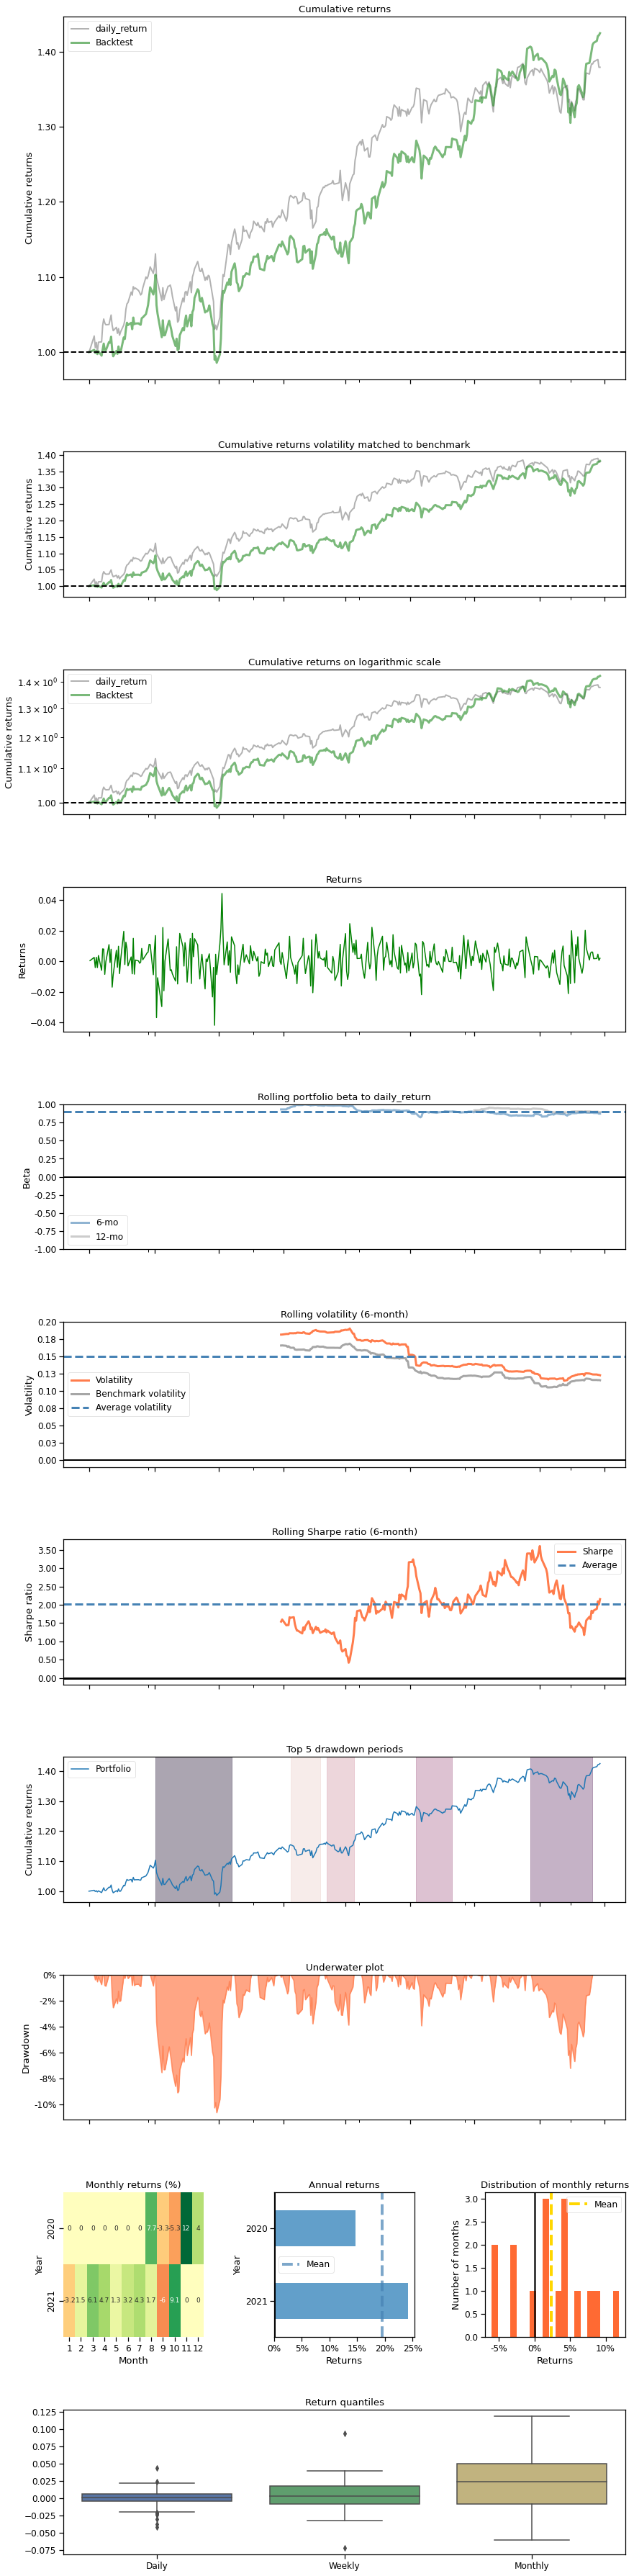

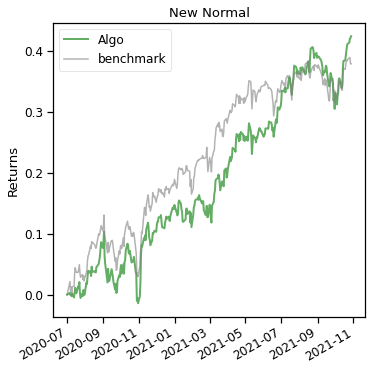

In [33]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value2)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'2.csv')
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value2.loc[0,'date'],
        end = df_account_value2.loc[len(df_account_value2)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value2, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value2.loc[0,'date'],
             baseline_end = df_account_value2.loc[len(df_account_value2)-1,'date'])